In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt


In [3]:
import pandas as pd# --- Data Loading and Preprocessing ---

file_path = '/home/abrar/Desktop/Code/Temporal HPC/synthetic_hpc_jobs_2020.csv'

# Load data
# time_columns = ['submit_time', 'eligible_time', 'start_time', 'end_time', 'wait_time']
df = pd.read_csv(file_path) #, parse_dates=time_columns

In [7]:
df.drop(['eligible_time', 'run_time_z', 'minute'], axis=1, inplace=True)

In [4]:
df.columns

Index(['job_id', 'submit_time', 'num_nodes_alloc', 'run_time',
       'mean_node_power', 'power_profile', 'cores_per_task', 'cores_per_node',
       'shared', 'priority', 'job_type', 'department', 'dependency_job_id',
       'memory_gb', 'state_reason', 'estimated_runtime', 'qos_level',
       'actual_runtime'],
      dtype='object')

In [9]:
# get the count of each unique value in the 'Name' column
value_counts = df['job_state'].value_counts()

print(value_counts)

job_state
COMPLETED        95076
FAILED           15284
CANCELLED         5825
TIMEOUT           4670
OUT_OF_MEMORY      592
NODE_FAIL           74
Name: count, dtype: int64


In [5]:
df.head()

,job_id,submit_time,num_nodes_alloc,run_time,mean_node_power,power_profile,cores_per_task,cores_per_node,shared,priority,job_type,department,dependency_job_id,memory_gb,state_reason,estimated_runtime,qos_level,actual_runtime
0,1,2020-05-01 00:09:21.667106,1,1201.672518,170.807258,"{'startup': 126.81889268858644, 'compute': 170...",2,16,0,5,small_fast,research,NaN,18.693180,NaN,1101.322836,standard,1201.672518
1,2,2020-05-01 00:35:55.170543,3,984.104976,178.517596,"{'startup': 126.62076050120143, 'compute': 178...",1,16,0,3,small_fast,research,NaN,91.706385,TimeLimit,1105.503122,standard,984.104976
2,3,2020-05-01 00:43:55.178191,15,2459.006468,299.035382,"{'startup': 248.94828829558773, 'compute': 299...",4,16,0,4,medium,research,NaN,137.638871,TimeLimit,2729.627825,urgent,2393.894362
3,4,2020-05-01 01:35:52.439924,3,1081.251390,196.117202,"{'startup': 169.78797807400898, 'compute': 196...",4,16,0,5,small_fast,production,NaN,23.837635,NaN,897.244307,urgent,1081.251390
4,5,2020-05-01 01:53:41.378462,3,1523.192143,170.685734,"{'startup': 151.10128321139337, 'compute': 170...",1,16,1,4,small_fast,production,NaN,49.753857,NaN,1444.484693,standard,1523.192143


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20980 entries, 0 to 20979
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   job_id             20980 non-null  int64  
 1   submit_time        20980 non-null  object 
 2   num_nodes_alloc    20980 non-null  int64  
 3   run_time           20980 non-null  float64
 4   mean_node_power    20980 non-null  float64
 5   power_profile      20980 non-null  object 
 6   cores_per_task     20980 non-null  int64  
 7   cores_per_node     20980 non-null  int64  
 8   shared             20980 non-null  int64  
 9   priority           20980 non-null  int64  
 10  job_type           20980 non-null  object 
 11  department         20980 non-null  object 
 12  dependency_job_id  3197 non-null   float64
 13  memory_gb          20980 non-null  float64
 14  state_reason       1761 non-null   object 
 15  estimated_runtime  20980 non-null  float64
 16  qos_level          209

In [7]:
# df.drop('eligible_time', axis=1, inplace=True)
df.describe()

,job_id,num_nodes_alloc,run_time,mean_node_power,cores_per_task,cores_per_node,shared,priority,dependency_job_id,memory_gb,estimated_runtime,actual_runtime
count,20980.00000,20980.000000,20980.000000,20980.000000,20980.000000,20980.0,20980.000000,20980.000000,3197.000000,20980.000000,20980.000000,20980.000000
mean,10490.50000,20.962011,4931.172242,388.952252,6.246378,16.0,0.307912,3.889657,10608.773225,375.096792,4929.562077,4912.985782
std,6056.54866,27.289396,3951.467152,281.842216,4.987297,0.0,0.461641,0.836211,6022.993327,556.812058,4018.815278,3938.739534
min,1.00000,1.000000,300.043907,100.015345,1.000000,16.0,0.000000,1.000000,10.000000,4.002438,243.861490,263.929234
25%,5245.75000,3.000000,1360.267784,169.731988,2.000000,16.0,0.000000,3.000000,5422.000000,41.869513,1341.296133,1355.731441
50%,10490.50000,9.000000,4103.130821,291.530877,4.000000,16.0,0.000000,4.000000,10607.000000,133.143716,4055.556798,4082.892466
75%,15735.25000,32.000000,7624.907641,538.224078,8.000000,16.0,1.000000,5.000000,15835.000000,445.262451,7639.847872,7594.275964
max,20980.00000,127.000000,14398.576168,1199.572687,16.000000,16.0,1.000000,5.000000,20977.000000,4030.931756,16883.792211,14398.576168


In [63]:
unique_priorities = df['priority'].unique()
print(unique_priorities)

df.info()

[1 0]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390134 entries, 0 to 390133
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   job_id           390134 non-null  int64         
 1   job_state        390134 non-null  object        
 2   submit_time      390134 non-null  datetime64[ns]
 3   start_time       390134 non-null  datetime64[ns]
 4   end_time         390134 non-null  datetime64[ns]
 5   wait_time        390134 non-null  object        
 6   cores_per_task   390134 non-null  int64         
 7   shared           390134 non-null  int64         
 8   priority         390134 non-null  int64         
 9   num_tasks        390134 non-null  float64       
 10  state_reason     390134 non-null  object        
 11  num_cores_alloc  390134 non-null  int64         
 12  num_nodes_alloc  390134 non-null  int64         
 13  num_gpus_alloc   390134 non-null  int64         
 14  mem_alloc     

# Feature importance analysis

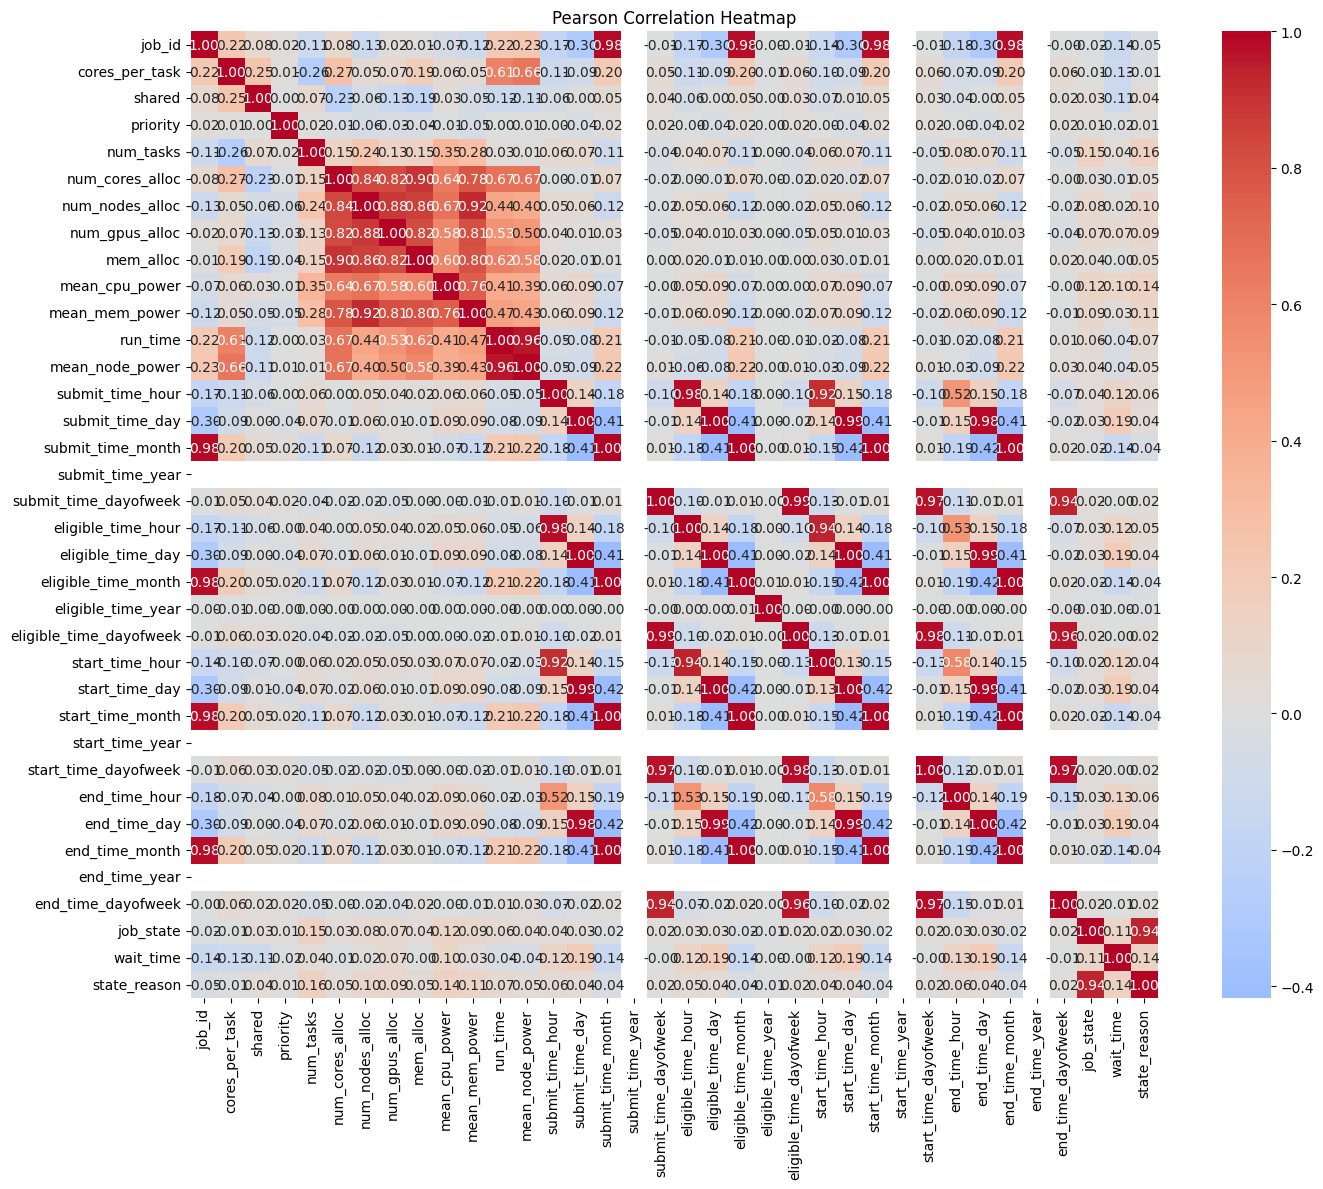

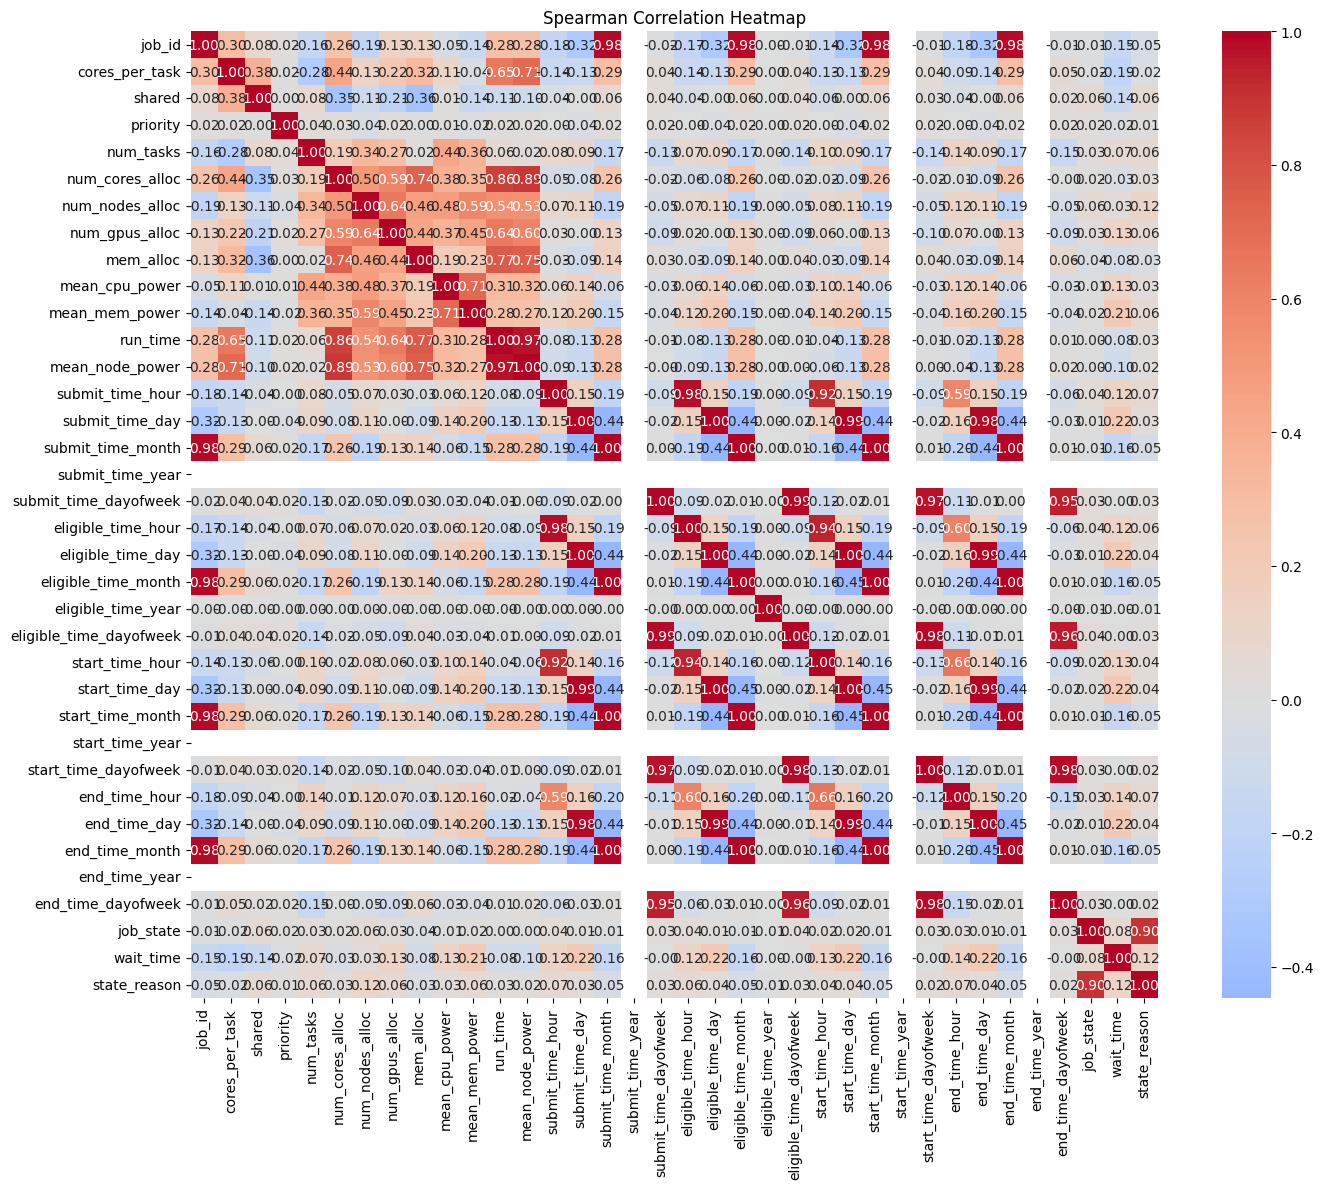

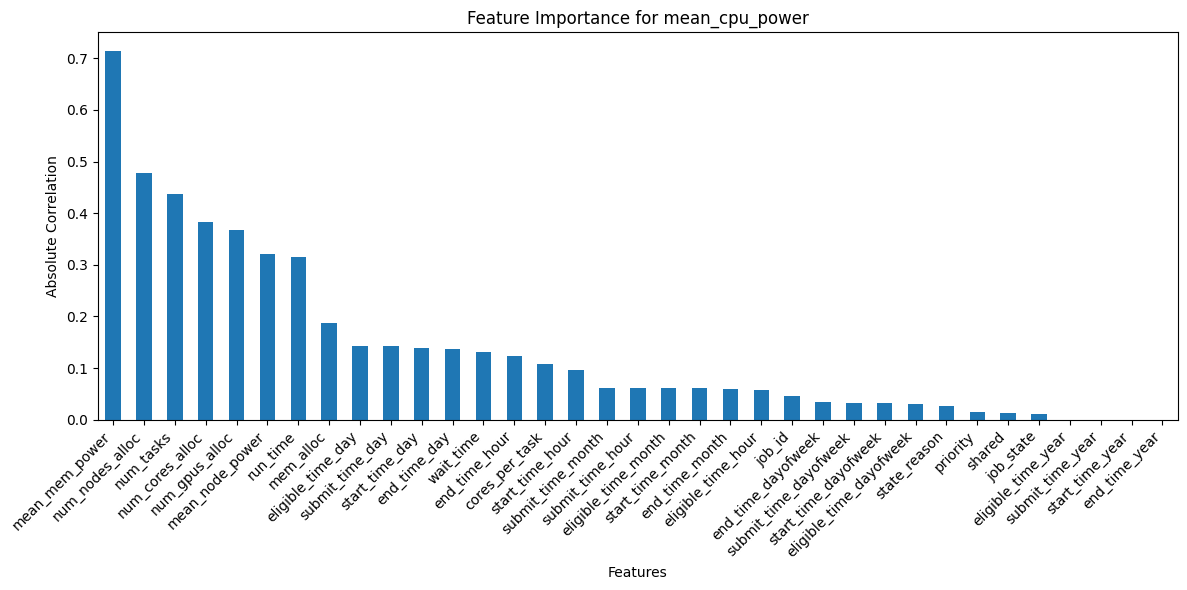

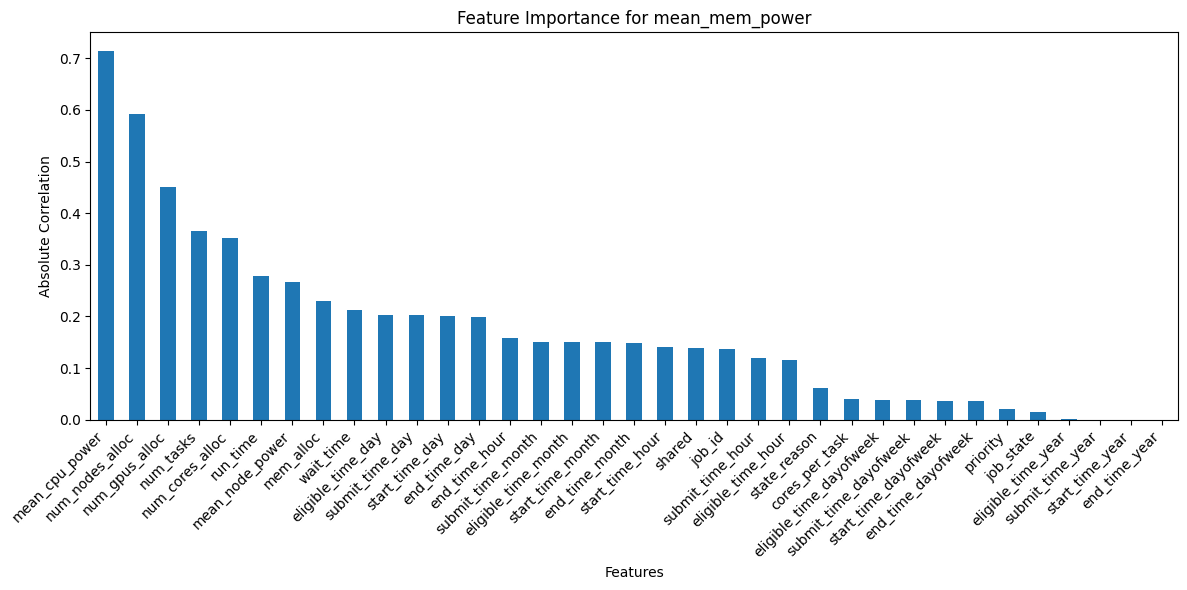

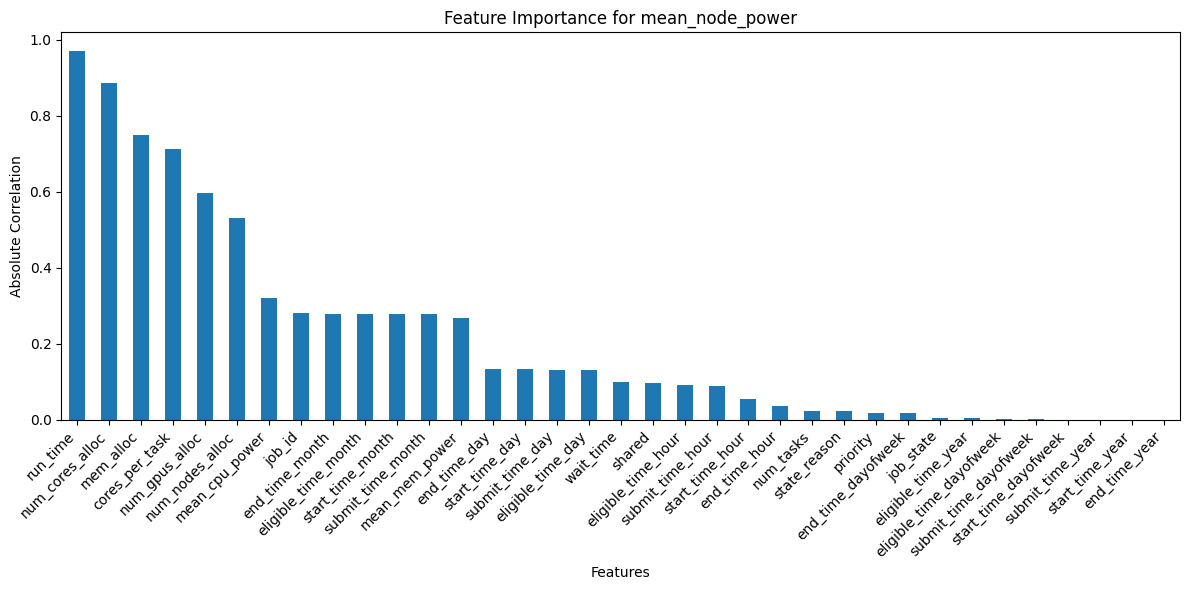

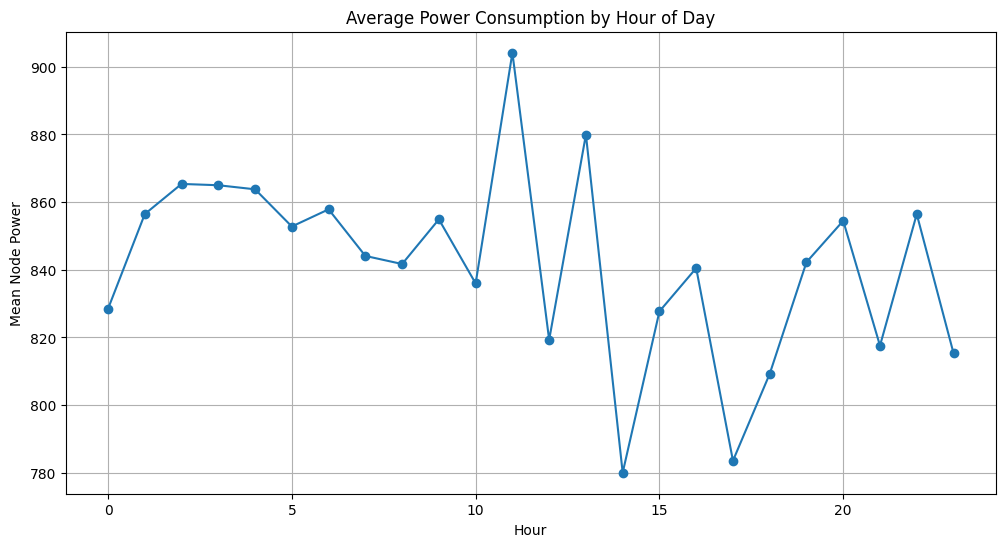

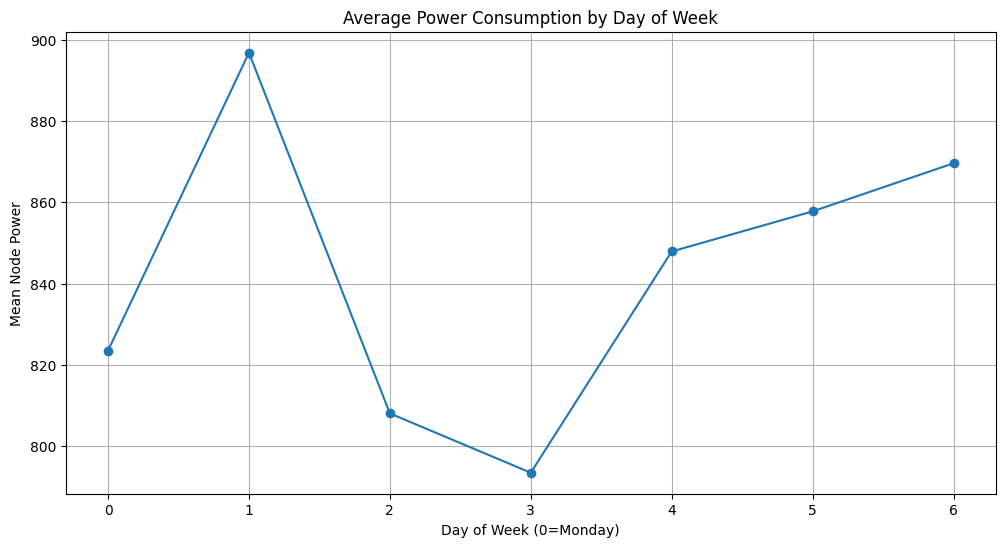

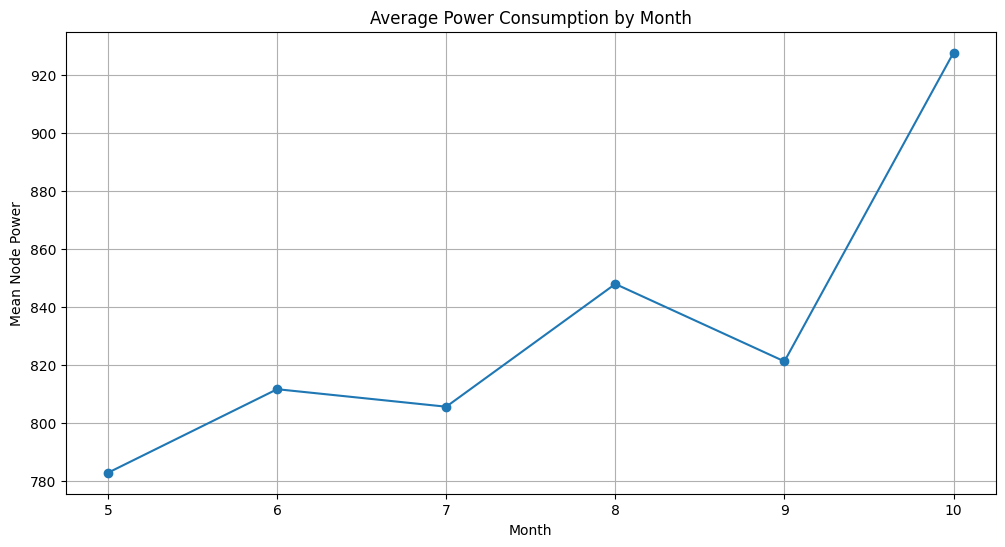


Top 10 correlations for mean_node_power:
run_time: 0.971
num_cores_alloc: 0.887
mem_alloc: 0.750
cores_per_task: 0.714
num_gpus_alloc: 0.597
num_nodes_alloc: 0.531
mean_cpu_power: 0.321
job_id: 0.281
submit_time_year: nan
start_time_year: nan


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def comprehensive_correlation_analysis(df):
    """
    Perform comprehensive correlation analysis across different data types
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with mixed data types
    
    Returns:
    dict: Dictionary containing different correlation matrices and processed data
    """
    # Separate columns by data type
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    
    # Process datetime columns
    datetime_features = {}
    for col in datetime_cols:
        datetime_features[f'{col}_hour'] = df[col].dt.hour
        datetime_features[f'{col}_day'] = df[col].dt.day
        datetime_features[f'{col}_month'] = df[col].dt.month
        datetime_features[f'{col}_year'] = df[col].dt.year
        datetime_features[f'{col}_dayofweek'] = df[col].dt.dayofweek
    
    datetime_df = pd.DataFrame(datetime_features)
    
    # Process categorical columns
    categorical_encoded = {}
    for col in categorical_cols:
        le = LabelEncoder()
        categorical_encoded[col] = le.fit_transform(df[col])
    
    categorical_df = pd.DataFrame(categorical_encoded)
    
    # Combine all processed features
    processed_df = pd.concat([
        df[numeric_cols].reset_index(drop=True),
        datetime_df.reset_index(drop=True),
        categorical_df.reset_index(drop=True)
    ], axis=1)
    
    # Calculate different correlation matrices
    pearson_corr = processed_df.corr(method='pearson')
    spearman_corr = processed_df.corr(method='spearman')
    
    # Calculate feature importance based on correlation with target variables
    power_cols = ['mean_cpu_power', 'mean_mem_power', 'mean_node_power']
    feature_importance = {}
    
    for target in power_cols:
        importance = {}
        for col in processed_df.columns:
            if col != target:
                correlation = abs(spearman_corr.loc[target, col])
                importance[col] = correlation
        feature_importance[target] = importance
    
    return {
        'pearson_corr': pearson_corr,
        'spearman_corr': spearman_corr,
        'feature_importance': feature_importance,
        'processed_df': processed_df
    }

def plot_correlation_heatmaps(correlation_results):
    """
    Plot correlation heatmaps with different methods
    """
    # Plot Pearson correlation
    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation_results['pearson_corr'], 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f',
                square=True)
    plt.title('Pearson Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    # Plot Spearman correlation
    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation_results['spearman_corr'], 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f',
                square=True)
    plt.title('Spearman Correlation Heatmap')
    plt.tight_layout()
    plt.show()

def plot_feature_importance(correlation_results):
    """
    Plot feature importance for power-related targets
    """
    power_cols = ['mean_cpu_power', 'mean_mem_power', 'mean_node_power']
    
    for target in power_cols:
        importances = correlation_results['feature_importance'][target]
        importance_df = pd.DataFrame.from_dict(importances, 
                                             orient='index', 
                                             columns=['importance'])
        importance_df = importance_df.sort_values('importance', ascending=False)
        
        plt.figure(figsize=(12, 6))
        importance_df['importance'].plot(kind='bar')
        plt.title(f'Feature Importance for {target}')
        plt.xlabel('Features')
        plt.ylabel('Absolute Correlation')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

def analyze_temporal_patterns(df):
    """
    Analyze temporal patterns in power consumption
    """
    # Hourly patterns
    plt.figure(figsize=(12, 6))
    df.groupby(df['submit_time'].dt.hour)['mean_node_power'].mean().plot(kind='line', marker='o')
    plt.title('Average Power Consumption by Hour of Day')
    plt.xlabel('Hour')
    plt.ylabel('Mean Node Power')
    plt.grid(True)
    plt.show()
    
    # Daily patterns
    plt.figure(figsize=(12, 6))
    df.groupby(df['submit_time'].dt.dayofweek)['mean_node_power'].mean().plot(kind='line', marker='o')
    plt.title('Average Power Consumption by Day of Week')
    plt.xlabel('Day of Week (0=Monday)')
    plt.ylabel('Mean Node Power')
    plt.grid(True)
    plt.show()
    
    # Monthly patterns
    plt.figure(figsize=(12, 6))
    df.groupby(df['submit_time'].dt.month)['mean_node_power'].mean().plot(kind='line', marker='o')
    plt.title('Average Power Consumption by Month')
    plt.xlabel('Month')
    plt.ylabel('Mean Node Power')
    plt.grid(True)
    plt.show()

# Usage example:

# Perform correlation analysis
correlation_results = comprehensive_correlation_analysis(df)

# Plot correlation heatmaps
plot_correlation_heatmaps(correlation_results)

# Plot feature importance
plot_feature_importance(correlation_results)

# Analyze temporal patterns
analyze_temporal_patterns(df)

# Print top correlations for power consumption
power_cols = ['mean_node_power']
for target in power_cols:
    print(f"\nTop 10 correlations for {target}:")
    importances = correlation_results['feature_importance'][target]
    top_features = sorted(importances.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
    for feature, correlation in top_features:
        print(f"{feature}: {correlation:.3f}")


In [4]:
df['submit_to_start'] = (df['start_time'] - df['submit_time']).dt.total_seconds()
df['start_to_end'] = (df['end_time'] - df['start_time']).dt.total_seconds()
print(df[['submit_to_start', 'start_to_end']].describe())


       submit_to_start   start_to_end
count     1.913150e+05  191315.000000
mean      7.355223e+03    5767.465285
std       5.667289e+04    3777.954624
min       0.000000e+00       1.000000
25%       1.000000e+00    2858.000000
50%       2.000000e+00    5581.000000
75%       1.020000e+02    8422.000000
max       1.940532e+06   23330.000000


In [5]:
import scipy.stats as stats
df['run_time_z'] = stats.zscore(df['run_time'])
extreme_jobs = df[df['run_time_z'].abs() > 3]
print(extreme_jobs[['job_id', 'run_time', 'run_time_z']])


        job_id      run_time  run_time_z
68          69  19774.603935    3.707423
101        102  18262.942259    3.307302
150        151  17943.370784    3.222714
151        152  17778.171385    3.178988
153        154  18171.257237    3.283034
...        ...           ...         ...
150527  150528  17639.322208    3.142236
180529  180530  19163.851879    3.545763
180530  180531  19262.273290    3.571814
188297  188298  17854.430861    3.199173
189141  189142  17618.865775    3.136821

[488 rows x 3 columns]


/tmp/ipykernel_17927/2322343555.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.set_index('submit_time').resample('T').size().plot(title="Jobs per Minute")
/tmp/ipykernel_17927/2322343555.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.set_index('submit_time').resample('H').size().plot(title="Jobs per Hour")


<Axes: title={'center': 'Jobs per Hour'}, xlabel='submit_time'>

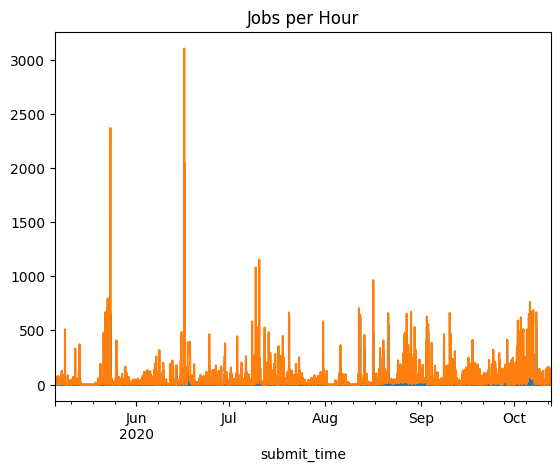

In [6]:
df.set_index('submit_time').resample('T').size().plot(title="Jobs per Minute")
df.set_index('submit_time').resample('H').size().plot(title="Jobs per Hour")


<Axes: >

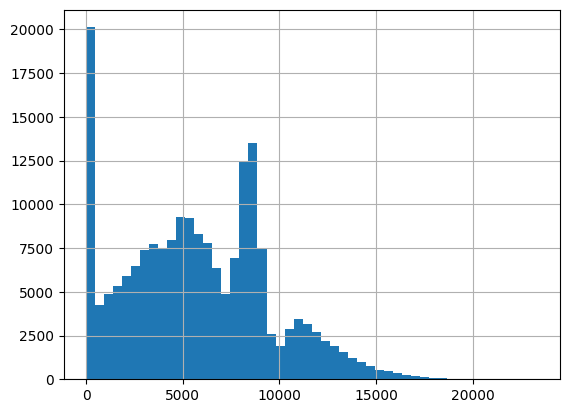

In [7]:
df['run_time'].hist(bins=50)


In [10]:
features =['run_time']

In [ ]:
# Assuming 'run_time' is a numpy array or pandas Series
upper_bound = np.percentile(features['run_time'], 99)
features['run_time_clipped'] = np.clip(features['run_time'], None, upper_bound)


In [ ]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()
robust_scaled_features = robust_scaler.fit_transform(features)


In [8]:
submissions_per_day = df.set_index('submit_time').resample('D').size()
print(submissions_per_day.describe())


count      161.000000
mean      1188.291925
std       1359.260671
min          0.000000
25%        464.000000
50%        846.000000
75%       1471.000000
max      11119.000000
dtype: float64


In [52]:
df_run_time = df[['start_time', 'end_time', 'run_time']].copy()
df_run_time['calc_run_time'] =  df['end_time'] - df['start_time']
df_run_time['calc_run_time'] = df_run_time['calc_run_time'].dt.total_seconds()
df_run_time['diff'] = df_run_time['run_time'] - df_run_time['calc_run_time']
# df_run_time['diff'] = df_run_time['run_time'] - df_run_time['calc_run_time']

In [54]:
df_run_time['diff'].describe()

count    390134.000000
mean        129.409601
std       12161.407249
min     -121426.216193
25%       -1873.105542
50%        1862.423725
75%        5697.125865
max       23291.168557
Name: diff, dtype: float64

In [5]:
start_date = df['submit_time'].min()
end_date = df['submit_time'].max()
print("Start Date:", start_date)
print("End Date:", end_date)

Start Date: 2020-05-05 15:55:59
End Date: 2020-10-12 23:50:26


In [8]:
print(df.head())

   job_id  job_state         submit_time          start_time  \
0       1    TIMEOUT 2020-05-05 15:55:59 2020-05-05 15:56:00   
1       2    TIMEOUT 2020-05-05 16:01:00 2020-05-05 16:01:00   
2       3    TIMEOUT 2020-05-05 16:21:46 2020-05-05 16:21:47   
3       4    TIMEOUT 2020-05-05 20:53:46 2020-05-05 20:53:46   
4       5  COMPLETED 2020-05-06 06:41:32 2020-05-06 06:41:51   

             end_time wait_time  cores_per_task  shared  priority  num_tasks  \
0 2020-05-06 15:56:07   86407.0              32       1         1  12.852698   
1 2020-05-06 16:01:07   86407.0              32       1         1  12.852698   
2 2020-05-06 16:22:07   86420.0              32       1         1  12.852698   
3 2020-05-06 19:54:12   82826.0               1       1         1  12.852698   
4 2020-05-06 10:22:34   13243.0               4       1         1  12.852698   

  state_reason  num_cores_alloc  num_nodes_alloc  num_gpus_alloc  mem_alloc  \
0    TimeLimit              128                1       

In [9]:
import pandas as pd
import numpy as np
from collections import defaultdict

def analyze_submission_granularity(df):
    """
    Analyze the granularity of job submissions at minute and hour levels.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with 'submit_time' column
    
    Returns:
    dict: Statistics about submission granularity
    """
    # Create minute and hour groupings
    df_minute = df.groupby(df['submit_time'].dt.strftime('%Y-%m-%d %H:%M')).size()
    df_hour = df.groupby(df['submit_time'].dt.strftime('%Y-%m-%d %H')).size()
    
    # Calculate statistics
    stats = {
        'minute_level': {
            'max_jobs': df_minute.max(),
            'avg_jobs': df_minute.mean(),
            'median_jobs': df_minute.median(),
            'std_jobs': df_minute.std(),
            'total_minutes_with_submissions': len(df_minute),
            'minutes_with_multiple_jobs': len(df_minute[df_minute > 1]),
            'distribution': df_minute.value_counts().sort_index().to_dict()
        },
        'hour_level': {
            'max_jobs': df_hour.max(),
            'avg_jobs': df_hour.mean(),
            'median_jobs': df_hour.median(),
            'std_jobs': df_hour.std(),
            'total_hours_with_submissions': len(df_hour),
            'hours_with_multiple_jobs': len(df_hour[df_hour > 1]),
            'distribution': df_hour.value_counts().sort_index().to_dict()
        }
    }
    
    # Calculate percentage of minutes/hours with multiple submissions
    stats['minute_level']['percent_multiple_submissions'] = (
        stats['minute_level']['minutes_with_multiple_jobs'] / 
        stats['minute_level']['total_minutes_with_submissions'] * 100
    )
    
    stats['hour_level']['percent_multiple_submissions'] = (
        stats['hour_level']['hours_with_multiple_jobs'] / 
        stats['hour_level']['total_hours_with_submissions'] * 100
    )
    
    return stats

def get_busiest_periods(df, top_n=5):
    """
    Find the busiest periods at minute and hour granularity.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with 'submit_time' column
    top_n (int): Number of busiest periods to return
    
    Returns:
    dict: Busiest periods with their job counts
    """
    # Group by minute and hour
    minute_counts = df.groupby(df['submit_time'].dt.strftime('%Y-%m-%d %H:%M')).size()
    hour_counts = df.groupby(df['submit_time'].dt.strftime('%Y-%m-%d %H')).size()
    
    busiest_periods = {
        'minutes': minute_counts.nlargest(top_n).to_dict(),
        'hours': hour_counts.nlargest(top_n).to_dict()
    }
    
    return busiest_periods

def print_granularity_analysis(stats, busiest_periods):
    """
    Print a formatted analysis of the submission granularity.
    """
    print("=== Job Submission Granularity Analysis ===\n")
    
    print("Minute-level Statistics:")
    print(f"- Average jobs per minute with submissions: {stats['minute_level']['avg_jobs']:.2f}")
    print(f"- Maximum jobs in a single minute: {stats['minute_level']['max_jobs']}")
    print(f"- Median jobs per minute: {stats['minute_level']['median_jobs']:.2f}")
    print(f"- Total minutes with submissions: {stats['minute_level']['total_minutes_with_submissions']}")
    print(f"- Minutes with multiple submissions: {stats['minute_level']['minutes_with_multiple_jobs']}")
    print(f"- Percentage of minutes with multiple submissions: {stats['minute_level']['percent_multiple_submissions']:.2f}%\n")
    
    print("Hour-level Statistics:")
    print(f"- Average jobs per hour with submissions: {stats['hour_level']['avg_jobs']:.2f}")
    print(f"- Maximum jobs in a single hour: {stats['hour_level']['max_jobs']}")
    print(f"- Median jobs per hour: {stats['hour_level']['median_jobs']:.2f}")
    print(f"- Total hours with submissions: {stats['hour_level']['total_hours_with_submissions']}")
    print(f"- Hours with multiple submissions: {stats['hour_level']['hours_with_multiple_jobs']}")
    print(f"- Percentage of hours with multiple submissions: {stats['hour_level']['percent_multiple_submissions']:.2f}%\n")
    
    print("Top 5 Busiest Minutes:")
    for timestamp, count in busiest_periods['minutes'].items():
        print(f"- {timestamp}: {count} jobs")
    
    print("\nTop 5 Busiest Hours:")
    for timestamp, count in busiest_periods['hours'].items():
        print(f"- {timestamp}: {count} jobs")



'\n# Analyze submission granularity\nstats = analyze_submission_granularity(df)\nbusiest_periods = get_busiest_periods(df)\nprint_granularity_analysis(stats, busiest_periods)\n\n# Access specific statistics\nprint(f"\nDistribution of jobs per minute:")\nfor jobs, count in sorted(stats[\'minute_level\'][\'distribution\'].items()):\n    print(f"{jobs} job(s): {count} minutes")\n'

In [ ]:
# Usage example:

# Analyze submission granularity
stats = analyze_submission_granularity(df)
busiest_periods = get_busiest_periods(df)
print_granularity_analysis(stats, busiest_periods)

# Access specific statistics
print(f"\nDistribution of jobs per minute:")
for jobs, count in sorted(stats['minute_level']['distribution'].items()):
    print(f"{jobs} job(s): {count} minutes")

# GNN Model


/tmp/ipykernel_10584/3254183171.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=time_columns)


PowerPredictionGNN(
  (node_embed): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv1): GCNConv(128, 128)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(128, 128)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GCNConv(128, 128)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (power_pred): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
Starting training...
Epoch 001, Train Loss: 0.22

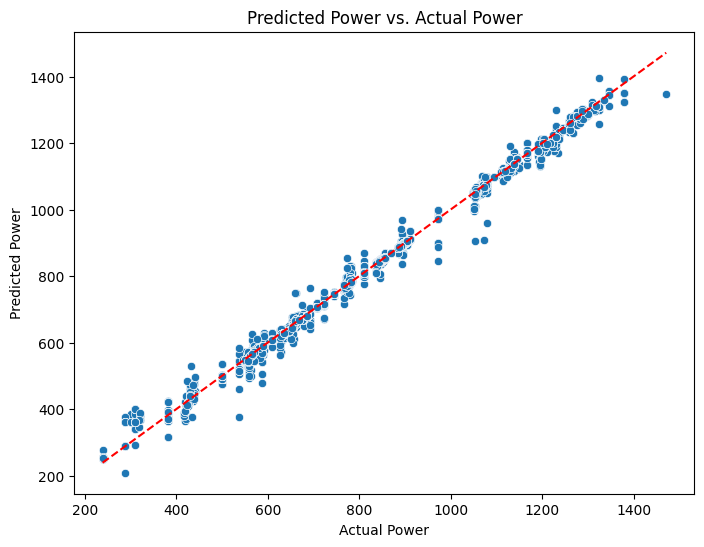

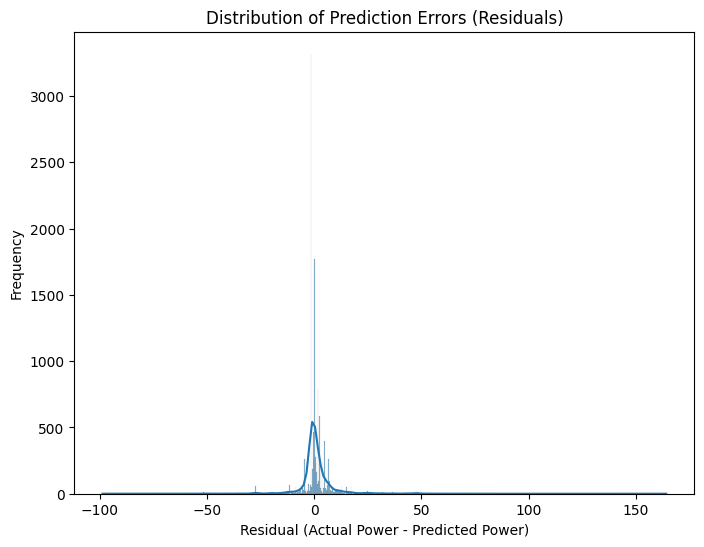

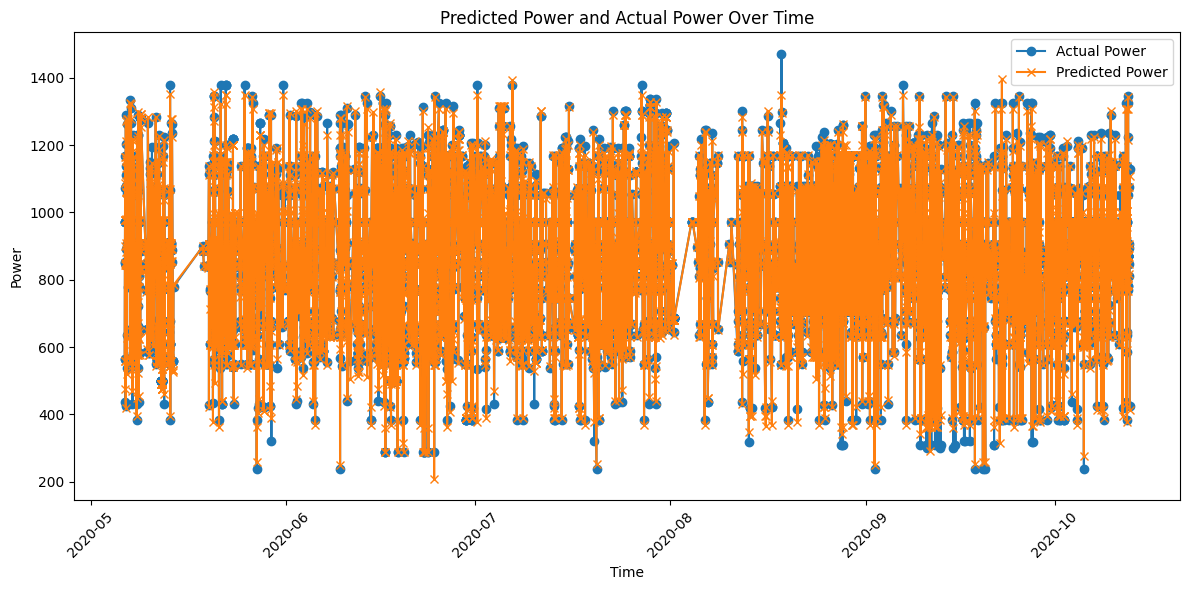

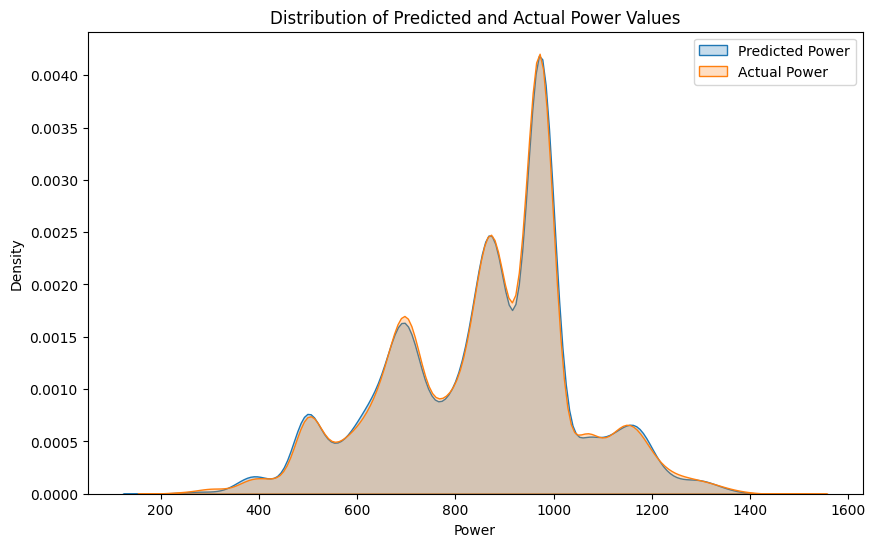

In [10]:
# --- Data Loading and Preprocessing ---

file_path = '/home/abrar/Desktop/Code/Temporal HPC/normalized_data.csv'

# Load data
time_columns = ['submit_time', 'eligible_time', 'start_time', 'end_time', 'wait_time']
df = pd.read_csv(file_path, parse_dates=time_columns)

# Feature Engineering (Simplified for GNN Focus)
df['hour_of_day'] = df['submit_time'].dt.hour
df['day_of_week'] = df['submit_time'].dt.day_name()
df['month'] = df['submit_time'].dt.month

corr_cols = ['cores_per_task', 'num_tasks', 'num_cores_alloc', 'num_nodes_alloc',
             'num_gpus_alloc', 'mem_alloc', 'mean_cpu_power', 'mean_mem_power',
             'mean_node_power', 'run_time']
correlation_matrix = df[corr_cols].corr()
# print("\nCorrelation matrix:")
# print(correlation_matrix)

# --- Stratified Splitting (Keep, but simplified) ---

# Create simplified stratification based on core allocation and runtime
df['size_group'] = pd.cut(df['num_cores_alloc'],
                         bins=[0, 32, 64, 128, 256, float('inf')],
                         labels=['very_small', 'small', 'medium', 'large', 'very_large'])
df['runtime_group'] = pd.cut(df['run_time'],
                            bins=[0, 2000, 4000, 6000, 8000, float('inf')],
                            labels=['very_short', 'short', 'medium', 'long', 'very_long'])
df['strata'] = df['size_group'].astype(str) + '_' + df['runtime_group'].astype(str)

# Remove small strata
valid_strata = df['strata'].value_counts()[df['strata'].value_counts() >= 20].index
df_filtered = df[df['strata'].isin(valid_strata)].copy()

# Split data (stratified)
train_val_idx, test_idx = train_test_split(
    df_filtered.index, test_size=0.1, stratify=df_filtered['strata'], random_state=42
)
train_idx, val_idx = train_test_split(
    train_val_idx, test_size=0.111, stratify=df_filtered.loc[train_val_idx, 'strata'], random_state=42
)

gnn_train_data = df_filtered.loc[train_idx]
gnn_val_data = df_filtered.loc[val_idx]
gnn_test_data = df_filtered.loc[test_idx]

# --- GNN Data Preparation ---

# Features and Target (Clearly Defined)
gnn_features = [
    'cores_per_task', 'num_cores_alloc', 'num_nodes_alloc',
    'num_gpus_alloc', 'mem_alloc', 'shared', 'priority',
    'num_tasks',
]


power_target = ['mean_node_power']

def prepare_gnn_data(df, features, target, feature_scaler=None, power_scaler=None):
    """
    Prepares data for GNN, including feature scaling and neighbor calculation.
    """
    # Fit scalers only on training data, transform others
    if feature_scaler is None:
        feature_scaler = StandardScaler()
        X = feature_scaler.fit_transform(df[features])
    else:
        X = feature_scaler.transform(df[features])

    if power_scaler is None:
        power_scaler = StandardScaler()
        y = power_scaler.fit_transform(df[target])
    else:
        y = power_scaler.transform(df[target])

    # KNN calculation
    knn = NearestNeighbors(n_neighbors=6)  # k=5 + 1 (itself)
    knn.fit(X)
    distances, indices = knn.kneighbors(X)
    neighbor_indices = indices[:, 1:]

    return X, y, neighbor_indices, feature_scaler, power_scaler

def create_graph_batch(features, neighbor_indices, targets, batch_size=1024):
    """
    Creates graph batches with edges based on KNN.
    """
    graphs = []
    num_samples = len(features)
    
    for i in range(0, num_samples, batch_size):
        batch_end = min(i + batch_size, num_samples)
        batch_features = features[i:batch_end]
        batch_neighbors = neighbor_indices[i:batch_end]
        batch_targets = targets[i:batch_end]
        
        # Create edges based on KNN within this batch
        edge_index = []
        
        for job_idx, neighbors in enumerate(batch_neighbors):
            for neighbor_idx in neighbors:
                # Convert global indices to local batch indices
                local_job_idx = job_idx
                local_neighbor_idx = neighbor_idx - i
        
                # Only add edges for neighbors that are within this batch
                if 0 <= local_neighbor_idx < len(batch_features):
                    edge_index.append([local_job_idx, local_neighbor_idx])
                    edge_index.append([local_neighbor_idx, local_job_idx])
        
        if not edge_index:  # If no valid edges in this batch
            continue
            
        edge_index = torch.tensor(edge_index).t().contiguous()
        
        # Create graph with matching features and targets
        graph = Data(
            x=torch.FloatTensor(batch_features),
            edge_index=edge_index,
            y=torch.FloatTensor(batch_targets)  # Add dimension for consistency
        )
        graphs.append(graph)
        
    return graphs

# Prepare data (fit scalers on train, transform all)
train_X, train_y, train_neighbors, feature_scaler, power_scaler = prepare_gnn_data(gnn_train_data, gnn_features, power_target)
val_X, val_y, val_neighbors, _, _ = prepare_gnn_data(gnn_val_data, gnn_features, power_target, feature_scaler, power_scaler)
test_X, test_y, test_neighbors, _, _ = prepare_gnn_data(gnn_test_data, gnn_features, power_target, feature_scaler, power_scaler)

# Create graph batches
train_graphs = create_graph_batch(train_X, train_neighbors, train_y)
val_graphs = create_graph_batch(val_X, val_neighbors, val_y)
test_graphs = create_graph_batch(test_X, test_neighbors, test_y)

# --- GNN Model ---

class PowerPredictionGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(PowerPredictionGNN, self).__init__()

        self.node_embed = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )

        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)

        self.power_pred = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x, edge_index):
        x = self.node_embed(x)
        x1 = F.relu(self.bn1(self.conv1(x, edge_index)))
        x2 = F.relu(self.bn2(self.conv2(x1, edge_index))) + x1
        x3 = F.relu(self.bn3(self.conv3(x2, edge_index))) + x2
        return self.power_pred(x3)

# --- Loss Function and Training ---

def power_prediction_loss(pred_power, true_power):
    """
    Custom loss function: Normalized MSE + Relative Error
    """
    pred_power = pred_power.squeeze()
    true_power = true_power.squeeze()

    pred_norm = (pred_power - pred_power.mean()) / (pred_power.std() + 1e-8)
    true_norm = (true_power - true_power.mean()) / (true_power.std() + 1e-8)

    mse_loss = F.mse_loss(pred_norm, true_norm)
    relative_error = torch.abs(pred_power - true_power) / (torch.abs(true_power) + 1e-8)
    relative_loss = torch.mean(relative_error)

    return mse_loss + 0.5 * relative_loss

class EarlyStopping:
    def __init__(self, patience=15, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_gnn(model, train_graphs, val_graphs, config):
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    early_stopping = EarlyStopping(patience=config['early_stopping_patience'])

    train_losses = []
    val_losses = []

    for epoch in range(config['epochs']):
        model.train()
        train_loss = 0
        for graph in train_graphs:
            optimizer.zero_grad()
            out = model(graph.x, graph.edge_index)
            loss = power_prediction_loss(out, graph.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for graph in val_graphs:
                out = model(graph.x, graph.edge_index)
                val_loss += power_prediction_loss(out, graph.y).item()

        train_loss /= len(train_graphs)
        val_loss /= len(val_graphs)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return train_losses, val_losses

# --- Evaluation ---

def evaluate_predictions(model, test_graphs, power_scaler):
    model.eval()
    predictions = []
    true_values = []

    with torch.no_grad():
        for graph in test_graphs:
            pred = model(graph.x, graph.edge_index)
            pred = pred.squeeze().numpy().reshape(-1, 1)
            true = graph.y.squeeze().numpy().reshape(-1, 1)
            pred = power_scaler.inverse_transform(pred)
            true = power_scaler.inverse_transform(true)
            predictions.extend(pred.flatten())
            true_values.extend(true.flatten())

    predictions = np.array(predictions)
    true_values = np.array(true_values)

    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)

    results = {
        'mse': mse,
        'rmse': np.sqrt(mse),
        'mae': mae,
        'r2': r2,
        'mean_relative_error': np.mean(np.abs(predictions - true_values) / (true_values + 1e-8)),
        'mean_pred': np.mean(predictions),
        'mean_true': np.mean(true_values),
        'std_pred': np.std(predictions),
        'std_true': np.std(true_values)
    }

    for p in [25, 50, 75, 90]:
        error_percentile = np.percentile(np.abs(predictions - true_values), p)
        results[f'error_p{p}'] = error_percentile

    return results, predictions, true_values

# --- Training Configuration and Initialization ---

config = {
    'hidden_dim': 128,
    'learning_rate': 0.001,
    'batch_size': 1024,
    'epochs': 100,
    'early_stopping_patience': 15
}

input_dim = len(gnn_features)
model = PowerPredictionGNN(input_dim=input_dim, hidden_dim=config['hidden_dim'])
print(model)

# --- Training and Evaluation ---

print("Starting training...")
train_losses, val_losses = train_gnn(model, train_graphs, val_graphs, config)

print("Evaluating model...")
test_metrics, predictions, true_values = evaluate_predictions(model, test_graphs, power_scaler)
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# --- Visualization ---

# Create a DataFrame for easier plotting
plot_df = pd.DataFrame({'Predicted Power': predictions, 'Actual Power': true_values})

# 1. Scatter Plot of Predicted vs. Actual Power
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual Power', y='Predicted Power', data=plot_df)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], '--', color='red')  # Diagonal line
plt.title('Predicted Power vs. Actual Power')
plt.xlabel('Actual Power')
plt.ylabel('Predicted Power')
plt.show()

# 2. Histogram of Residuals (Prediction Errors)
residuals = plot_df['Actual Power'] - plot_df['Predicted Power']
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Residual (Actual Power - Predicted Power)')
plt.ylabel('Frequency')
plt.show()

# 3. Predicted and Actual Power Over Time (assuming you have a time index)
# You might need to adjust this depending on how your test data is ordered
if 'submit_time' in gnn_test_data.columns:
    time_index = gnn_test_data['submit_time'].iloc[:len(predictions)]  # Assuming predictions are in the same order
    plot_df['Time'] = time_index.values
    plot_df = plot_df.sort_values('Time')
    plt.figure(figsize=(12, 6))
    plt.plot(plot_df['Time'], plot_df['Actual Power'], label='Actual Power', marker='o')
    plt.plot(plot_df['Time'], plot_df['Predicted Power'], label='Predicted Power', marker='x')
    plt.title('Predicted Power and Actual Power Over Time')
    plt.xlabel('Time')
    plt.ylabel('Power')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Warning: 'submit_time' column not found in test data. Skipping time-based plot.")

# 4. Distribution of Predicted vs Actual
plt.figure(figsize=(10, 6))
sns.kdeplot(plot_df['Predicted Power'], label='Predicted Power', fill=True)
sns.kdeplot(plot_df['Actual Power'], label='Actual Power', fill=True)
plt.title('Distribution of Predicted and Actual Power Values')
plt.xlabel('Power')
plt.ylabel('Density')
plt.legend()
plt.show()

RL implementation on top of the GNN

RL HPC Environment

In [49]:
class HPCEnvironment:
    def __init__(self, gnn_model, feature_scaler, power_scaler, num_nodes=100):
        self.gnn_model = gnn_model
        self.feature_scaler = feature_scaler
        self.power_scaler = power_scaler
        self.num_nodes = num_nodes
        self.peak_hour_cost = 2.5
        self.off_peak_cost = 0.6
        self.reset()

    def reset(self):
        """Reset environment state"""
        self.node_status = [True] * self.num_nodes
        self.current_time = pd.Timestamp.now().replace(hour=0, minute=0)
        self.running_jobs = []
        self.energy_consumption = 0
        self.peak_consumption = 0
        self.total_cost = 0
        return self._get_state()

    def _get_state(self):
        """Enhanced state representation with stronger time signals"""
        is_peak_hour = 1.0 if 8 <= self.current_time.hour < 20 else 0.0
        
        # Time features
        hour_of_day = self.current_time.hour / 24.0
        minutes = self.current_time.minute / 60.0
        time_to_peak = (8 - self.current_time.hour) / 24.0 if self.current_time.hour < 8 else \
                       (20 - self.current_time.hour) / 24.0 if 8 <= self.current_time.hour < 20 else \
                       (32 - self.current_time.hour) / 24.0
        
        return np.array([
            sum(self.node_status) / self.num_nodes,  # Available nodes
            len(self.running_jobs) / self.num_nodes,  # System load
            hour_of_day,  # Normalized hour
            minutes,  # Normalized minutes
            is_peak_hour,  # Peak hour indicator
            time_to_peak,  # Time until next price change
            self.peak_consumption / (self.energy_consumption + 1e-8),  # Peak ratio
            len(self.waiting_jobs) / 50 if hasattr(self, 'waiting_jobs') else 0  # Queue pressure
        ])
    
    def _can_schedule(self, job):
        """Check if job can be scheduled"""
        return sum(self.node_status) >= job['num_nodes_alloc']

    def _allocate_nodes(self, job):
        """Allocate nodes to a job"""
        nodes_needed = job['num_nodes_alloc']
        allocated_nodes = []
        
        for i, available in enumerate(self.node_status):
            if available and len(allocated_nodes) < nodes_needed:
                allocated_nodes.append(i)
                self.node_status[i] = False
        
        return allocated_nodes

    def _update_running_jobs(self):
        """Update status of running jobs"""
        remaining_jobs = []
        for job, nodes, end_time in self.running_jobs:
            if end_time <= self.current_time:
                for node in nodes:
                    self.node_status[node] = True
                self.completed_jobs.append(job)
            else:
                remaining_jobs.append((job, nodes, end_time))
        self.running_jobs = remaining_jobs

    def _predict_power(self, job):
        """Predict power consumption for a job"""
        job_features = np.array([[job[f] for f in gnn_features]])
        scaled_features = self.feature_scaler.transform(job_features)
        x = torch.FloatTensor(scaled_features)
        edge_index = torch.tensor([[0], [0]], dtype=torch.long)
        
        self.gnn_model.eval()
        with torch.no_grad():
            pred = self.gnn_model(x, edge_index)
            pred = pred.squeeze().numpy().reshape(-1, 1)
            pred = self.power_scaler.inverse_transform(pred)
        return pred.item()

    def step(self, action, job):
        """Enhanced step function with proper time handling"""
        reward = 0
        done = False
        info = {'scheduled': False}
        
        is_peak_hour = 8 <= self.current_time.hour < 20
        power_price = self.peak_hour_cost if is_peak_hour else self.off_peak_cost
        
        if action == 0:  # Schedule now
            if self._can_schedule(job):
                power = self._predict_power(job)
                duration_hours = job['run_time'] / 3600
                
                # Calculate energy costs
                energy_cost = power * duration_hours * power_price
                min_possible_cost = power * duration_hours * self.off_peak_cost
                
                # Enhanced reward calculation
                if is_peak_hour:
                    power_penalty = -2.0 * (power / 1000)  # Penalty scales with power usage
                    time_penalty = -1.0 * (20 - self.current_time.hour) / 12  # Higher penalty earlier in peak period
                    reward = -5.0 + power_penalty + time_penalty
                else:
                    time_bonus = 1.0 * (8 - self.current_time.hour) / 8 if self.current_time.hour < 8 else \
                                1.0 * (self.current_time.hour - 20) / 4
                    reward = 2.0 + time_bonus
                
                # Update metrics
                self.energy_consumption += power * duration_hours
                self.total_cost += energy_cost
                if is_peak_hour:
                    self.peak_consumption += power * duration_hours
                
                info = {
                    'scheduled': True,
                    'energy_cost': energy_cost,
                    'is_peak': is_peak_hour,
                    'power': power
                }
            else:
                reward = -3.0  # Penalty for trying to schedule when resources aren't available
                self.current_time += pd.Timedelta(minutes=30)  # Advance time on failed scheduling
        else:  # Wait
            if is_peak_hour:
                reward = 1.0  # Base reward for waiting during peak
                if job['mean_node_power'] > 1000:  # Extra reward for delaying high-power jobs
                    reward += 1.0
            else:
                reward = -1.0  # Penalty for unnecessary waiting
            
            self.current_time += pd.Timedelta(minutes=30)
        
        # Check day end
        if self.current_time.hour >= 23:
            done = True
            # Final reward based on peak ratio
            peak_ratio = self.peak_consumption / (self.energy_consumption + 1e-8)
            if peak_ratio < 0.3:
                reward += 10.0
            elif peak_ratio > 0.6:
                reward -= 10.0
        
        return self._get_state(), reward, done, info

    
    def _predict_power(self, job):
        job_features = np.array([[job[f] for f in gnn_features]])
        scaled_features = self.feature_scaler.transform(job_features)
        x = torch.FloatTensor(scaled_features)
        edge_index = torch.tensor([[0], [0]], dtype=torch.long)
        
        self.gnn_model.eval()
        with torch.no_grad():
            pred = self.gnn_model(x, edge_index)
            pred = pred.squeeze().numpy().reshape(-1, 1)
            pred = self.power_scaler.inverse_transform(pred)
        return pred.item()
    
    def _can_schedule(self, job):
        return sum(self.node_status) >= job['num_nodes_alloc']
    
    def _allocate_nodes(self, job):
        nodes_needed = job['num_nodes_alloc']
        allocated_nodes = []
        
        for i, available in enumerate(self.node_status):
            if available and len(allocated_nodes) < nodes_needed:
                allocated_nodes.append(i)
                self.node_status[i] = False
                
        return allocated_nodes
    
    def _update_running_jobs(self):
        # Remove completed jobs and free their nodes
        remaining_jobs = []
        for job, nodes, end_time in self.running_jobs:
            if end_time <= self.current_time:
                for node in nodes:
                    self.node_status[node] = True
            else:
                remaining_jobs.append((job, nodes, end_time))
        self.running_jobs = remaining_jobs
    
    def _get_power_price(self):
        hour = self.current_time.hour
        if 8 <= hour < 20:  # Peak hours
            return 1.5
        return 1.0
    
    def get_expected_cost_difference(self, job):
        """Calculate cost difference between peak and off-peak scheduling"""
        power = job['mean_node_power']
        duration = job['run_time'] / 3600
        peak_cost = power * duration * self.peak_hour_cost
        off_peak_cost = power * duration * self.off_peak_cost
        return peak_cost - off_peak_cost

    def get_waiting_penalty(self, job):
        """Calculate penalty for waiting based on job characteristics"""
        waiting_jobs_count = len(self.waiting_jobs)
        system_load = len(self.running_jobs) / self.num_nodes
        urgency = min(job['run_time'] / 3600, 24)  # Cap at 24 hours
        
        base_penalty = -0.1 * waiting_jobs_count
        load_factor = -0.2 if system_load < 0.3 else 0.0  # Penalize waiting when system is underutilized
        urgency_factor = -0.1 * urgency / 24  # Higher penalty for long jobs
        
        return base_penalty + load_factor + urgency_factor

PPO agent

In [23]:
import random
class PPOMemory:
    def __init__(self, gamma=0.99, gae_lambda=0.95):
        self.states = []
        self.actions = []
        self.probs = []
        self.vals = []
        self.rewards = []
        self.dones = []
        self.gamma = gamma
        self.gae_lambda = gae_lambda
    
    def compute_advantages(self):
        returns = []
        advantages = []
        gae = 0
        
        for reward, value, done in zip(reversed(self.rewards), reversed(self.vals), reversed(self.dones)):
            if done:
                gae = 0
            
            delta = reward + self.gamma * next_value * (1 - done) - value
            gae = delta + self.gamma * self.gae_lambda * (1 - done) * gae
            advantage = gae
            
            advantages.insert(0, advantage)
            returns.insert(0, advantage + value)
            
            next_value = value

            return advantages, returns
    
    def generate_batches(self, batch_size):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+batch_size] for i in batch_start]
        return np.array(self.states),\
               np.array(self.actions),\
               np.array(self.probs),\
               np.array(self.vals),\
               np.array(self.rewards),\
               np.array(self.dones),\
               batches
    
    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)
    
    def clear_memory(self):
        self.states = []
        self.actions = []
        self.probs = []
        self.vals = []
        self.rewards = []
        self.dones = []

class ActorNetwork(nn.Module):
    def __init__(self, input_dims, n_actions=3, hidden_dim=256):
        super(ActorNetwork, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(input_dims, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, n_actions),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, state):
        return self.actor(state)

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, hidden_dim=256):
        super(CriticNetwork, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(input_dims, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, state):
        value = self.critic(state)
        return value
    

# 3. Add experience replay buffer
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done


class TrainingMetrics:
    def __init__(self):
        self.peak_schedules = 0
        self.off_peak_schedules = 0
        self.total_wait_time = 0
        self.energy_costs = []
        self.peak_ratios = []
        
    def update(self, time, action, energy_cost=0, is_peak=False):
        if action == 0:  # Schedule
            if is_peak:
                self.peak_schedules += 1
            else:
                self.off_peak_schedules += 1
            self.energy_costs.append(energy_cost)
        else:  # Wait
            self.total_wait_time += 1 if action == 1 else 4
            
    def get_summary(self):
        return {
            'peak_schedule_ratio': self.peak_schedules / (self.peak_schedules + self.off_peak_schedules + 1e-8),
            'total_wait_hours': self.total_wait_time,
            'avg_energy_cost': np.mean(self.energy_costs) if self.energy_costs else 0
        }

In [24]:
def update_policy(memory, actor, critic, actor_optimizer, critic_optimizer, clip_epsilon=0.2):
    advantages, returns = memory.compute_advantages()
    advantages = torch.tensor(advantages)
    returns = torch.tensor(returns)
    
    # Convert other data to tensors
    old_states = torch.FloatTensor(np.array(memory.states))
    old_actions = torch.LongTensor(np.array(memory.actions))
    old_probs = torch.FloatTensor(np.array(memory.probs))
    
    # Multiple epochs of training
    for _ in range(4):
        # Get current action probabilities and values
        action_probs = actor(old_states)
        values = critic(old_states)
        
        # Calculate probability ratio
        dist = Categorical(action_probs)
        new_probs = dist.log_prob(old_actions).exp()
        ratio = new_probs / old_probs
        
        # Calculate surrogate losses
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1-clip_epsilon, 1+clip_epsilon) * advantages
        actor_loss = -torch.min(surr1, surr2).mean()
        
        # Calculate value loss
        critic_loss = F.mse_loss(values.squeeze(), returns)
        
        # Update actor
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        
        # Update critic
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

In [25]:

# Create a job queue for testing
def prepare_job_queue(data, n_jobs=100):
    """Prepare a queue of jobs for testing"""
    jobs = data.sample(n=n_jobs).to_dict('records')
    # Sort by submit time to maintain temporal order
    jobs = sorted(jobs, key=lambda x: x['submit_time'])
    return jobs

In [26]:
def train_scheduler(env, n_episodes=1000):
    input_dims = 8  # Updated state dimension for enhanced state space
    n_actions = 2  # Schedule now or wait
    
    actor = ActorNetwork(input_dims, n_actions)
    critic = CriticNetwork(input_dims)
    memory = PPOMemory(gamma=0.99, gae_lambda=0.95)  # Add parameters
    
    # Add optimizers
    actor_optimizer = torch.optim.Adam(actor.parameters(), lr=0.0003)
    critic_optimizer = torch.optim.Adam(critic.parameters(), lr=0.0003)
    
    best_reward = float('-inf')
    train_jobs = prepare_job_queue(gnn_train_data, n_jobs=100)
    
    for episode in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        job_queue = train_jobs.copy()
        peak_schedules = 0
        total_schedules = 0
        
        while not done and len(job_queue) > 0:
            state_tensor = torch.FloatTensor(state)
            
            # Get action and value
            action_probs = actor(state_tensor)
            value = critic(state_tensor)
            dist = Categorical(action_probs)
            action = dist.sample()
            
            # Get next job and take action
            current_job = job_queue[0]
            next_state, reward, done, info = env.step(action.item(), current_job)
            
            # Track scheduling
            if info['scheduled']:
                total_schedules += 1
                job_queue.pop(0)
                if info.get('is_peak', False):
                    peak_schedules += 1
            
            # Store transition with value
            memory.store_memory(
                state, 
                action.item(), 
                action_probs[action.item()].item(),
                value.item(),
                reward, 
                done
            )
            
            state = next_state
            total_reward += reward
        
        # Update policy every episode
        update_policy(memory, actor, critic, actor_optimizer, critic_optimizer)
        memory.clear_memory()
        
        if episode % 10 == 0:
            peak_ratio = peak_schedules / (total_schedules + 1e-8)
            print(f'Episode {episode}:')
            print(f'Total Reward: {total_reward:.2f}')
            print(f'Energy Cost: ${env.total_cost:.2f}')
            print(f'Energy Usage: {env.energy_consumption:.2f} kWh')
            print(f'Peak Schedule Ratio: {peak_ratio:.2%}')
            print(f'Average Cost per kWh: ${env.total_cost/env.energy_consumption:.2f}\n')
        
        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(actor.state_dict(), 'best_scheduler_actor.pth')
            torch.save(critic.state_dict(), 'best_scheduler_critic.pth')

    return actor, critic

In [27]:
# import warnings
# warnings.filterwarnings("ignore")


In [28]:
# # First, verify we have all components
# print("Checking available components:")
# print(f"GNN Model available: {model is not None}")
# print(f"Feature scaler available: {feature_scaler is not None}")
# print(f"Power scaler available: {power_scaler is not None}")
# print(f"Training data size: {len(gnn_train_data)}")
# print(f"Test data size: {len(gnn_test_data)}")

# # Create a job queue for testing
# def prepare_job_queue(data, n_jobs=100):
#     """Prepare a queue of jobs for testing"""
#     jobs = data.sample(n=n_jobs).to_dict('records')
#     # Sort by submit time to maintain temporal order
#     jobs = sorted(jobs, key=lambda x: x['submit_time'])
#     return jobs

# # Create test function
# def test_scheduler(env, actor, jobs, episodes=5):
#     """Test the scheduler on a set of jobs"""
#     results = []
    
#     for episode in range(episodes):
#         state = env.reset()
#         done = False
#         episode_reward = 0
#         job_queue = jobs.copy()
        
#         while len(job_queue) > 0:
#             state_tensor = torch.FloatTensor(state)
            
#             # Get action probabilities
#             with torch.no_grad():
#                 action_probs = actor(state_tensor)
#                 dist = Categorical(action_probs)
#                 action = dist.sample()
            
#             # Get next job
#             current_job = job_queue[0]
            
#             # Take action
#             next_state, reward, done, _ = env.step(action.item(), current_job)
            
#             if action.item() == 0:  # If we scheduled the job
#                 job_queue.pop(0)
            
#             state = next_state
#             episode_reward += reward
        
#         results.append({
#             'episode': episode,
#             'total_reward': episode_reward,
#             'energy_cost': env.total_cost,
#             'energy_consumption': env.energy_consumption,
#             'avg_cost_per_kwh': env.total_cost / (env.energy_consumption + 1e-8)
#         })
        
#     return results

# # Run training and evaluation
# def run_experiment():
#     env = HPCEnvironment(
#         gnn_model=model,
#         feature_scaler=feature_scaler,
#         power_scaler=power_scaler,
#         num_nodes=100
#     )
    
#     input_dims = 8  # New state dimension
#     n_actions = 2
#     actor = ActorNetwork(input_dims, n_actions)
#     critic = CriticNetwork(input_dims)
    
#     # Use Adam optimizer with lower learning rate
#     actor_optimizer = torch.optim.Adam(actor.parameters(), lr=0.0001)
#     critic_optimizer = torch.optim.Adam(critic.parameters(), lr=0.0001)

#     # 2. Add learning rate scheduling to improve training
#     actor_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     actor_optimizer, mode='max', factor=0.5, patience=5, verbose=True
#     )
    

    
#     train_jobs = prepare_job_queue(gnn_train_data, n_jobs=1000)
#     test_jobs = prepare_job_queue(gnn_test_data, n_jobs=100)
    
#     print("\nStarting training...")
#     training_stats = []
#     best_reward = float('-inf')
    
#     for episode in range(100):
#         state = env.reset()
#         episode_rewards = []
#         episode_actions = []
#         episode_costs = []
#         job_queue = train_jobs.copy()
        
#         while len(job_queue) > 0:
#             state_tensor = torch.FloatTensor(state)
            
#             # Get action probabilities
#             action_probs = actor(state_tensor)
#             dist = Categorical(action_probs)
#             action = dist.sample()
            
#             # Get next job
#             current_job = job_queue[0]
            
#             # Take action
#             next_state, reward, done, info = env.step(action.item(), current_job)
            
#             if action.item() == 0 and info['scheduled']:
#                 job_queue.pop(0)
            
#             # Store transition
#             episode_rewards.append(reward)
#             episode_actions.append(action.item())
#             if 'energy_cost' in info:
#                 episode_costs.append(info['energy_cost'])
            
#             state = next_state
            
#             if done:
#                 break
        
#         # Calculate episode statistics
#         total_reward = sum(episode_rewards)
#         schedule_rate = sum(1 for a in episode_actions if a == 0) / len(episode_actions)
#         avg_reward = np.mean(episode_rewards)
        
#         training_stats.append({
#             'episode': episode,
#             'total_reward': total_reward,
#             'average_reward': avg_reward,
#             'schedule_rate': schedule_rate,
#             'energy_cost': env.total_cost,
#             'energy_consumption': env.energy_consumption
#         })
        
#         if episode % 10 == 0:
#             print(f"\nEpisode {episode}")
#             print(f"Total Reward: {total_reward:.2f}")
#             print(f"Average Reward: {avg_reward:.2f}")
#             print(f"Schedule Rate: {schedule_rate:.2%}")
#             print(f"Energy Cost: ${env.total_cost:.2f}")
#             print(f"Energy Consumption: {env.energy_consumption:.2f} kWh")
        
#         if total_reward > best_reward:
#             best_reward = total_reward
#             torch.save(actor.state_dict(), 'best_scheduler_actor.pth')
    
#     # Test the trained scheduler
#     print("\nTesting scheduler...")
#     test_results = test_scheduler(env, actor, test_jobs)
    
#     return training_stats, test_results

# def plot_results(training_stats, test_results):
#     """Plot training and testing results"""
#     fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
#     # Training rewards
#     episodes = [stat['episode'] for stat in training_stats]
#     rewards = [stat['reward'] for stat in training_stats]
#     axes[0, 0].plot(episodes, rewards)
#     axes[0, 0].set_title('Training Rewards')
#     axes[0, 0].set_xlabel('Episode')
#     axes[0, 0].set_ylabel('Total Reward')
    
#     # Energy costs
#     energy_costs = [stat['energy_cost'] for stat in training_stats]
#     axes[0, 1].plot(episodes, energy_costs)
#     axes[0, 1].set_title('Energy Costs During Training')
#     axes[0, 1].set_xlabel('Episode')
#     axes[0, 1].set_ylabel('Energy Cost ($)')
    
#     # Test results
#     test_episodes = range(len(test_results))
#     test_rewards = [r['total_reward'] for r in test_results]
#     test_costs = [r['energy_cost'] for r in test_results]
    
#     axes[1, 0].bar(test_episodes, test_rewards)
#     axes[1, 0].set_title('Test Episode Rewards')
#     axes[1, 0].set_xlabel('Test Episode')
#     axes[1, 0].set_ylabel('Total Reward')
    
#     axes[1, 1].bar(test_episodes, test_costs)
#     axes[1, 1].set_title('Test Episode Energy Costs')
#     axes[1, 1].set_xlabel('Test Episode')
#     axes[1, 1].set_ylabel('Energy Cost ($)')
    
#     plt.tight_layout()
#     plt.show()



# # First verify all imports worked
# print("Checking imports and components:")
# print(f"PyTorch version: {torch.__version__}")
# print(f"GNN Model available: {model is not None}")
# print(f"Feature scaler available: {feature_scaler is not None}")
# print(f"Power scaler available: {power_scaler is not None}")
# print(f"Training data size: {len(gnn_train_data)}")
# print(f"Test data size: {len(gnn_test_data)}")

# # Now try to run the experiment again
# try:
#     print("\nStarting experiment...")
#     training_stats, test_results = run_experiment()
    
#     # Print final results
#     print("\nFinal Test Results:")
#     avg_reward = np.mean([r['total_reward'] for r in test_results])
#     avg_cost = np.mean([r['energy_cost'] for r in test_results])
#     avg_consumption = np.mean([r['energy_consumption'] for r in test_results])
    
#     print(f"Average Test Reward: {avg_reward:.2f}")
#     print(f"Average Energy Cost: ${avg_cost:.2f}")
#     print(f"Average Energy Consumption: {avg_consumption:.2f} kWh")
    
# except Exception as e:
#     print(f"\nError occurred: {str(e)}")
#     print("Please check if all classes (HPCEnvironment, ActorNetwork, CriticNetwork) are defined")

In [29]:
# Add the ReplayBuffer class definition before the training loop
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, min(len(self.buffer), batch_size))
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

# Modify the training section
print("Starting experiment...")
env = HPCEnvironment(
    gnn_model=model,
    feature_scaler=feature_scaler,
    power_scaler=power_scaler,
    num_nodes=100
)

input_dims = 8  # New state dimension
n_actions = 2
actor = ActorNetwork(input_dims, n_actions)
critic = CriticNetwork(input_dims)

# Add optimizers and scheduler
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=0.001)
actor_scheduler = ReduceLROnPlateau(actor_optimizer, mode='max', factor=0.5, patience=5, verbose=True)

# Create replay buffer
buffer = ReplayBuffer(capacity=10000)
batch_size = 64

train_jobs = prepare_job_queue(gnn_train_data, n_jobs=1000)
test_jobs = prepare_job_queue(gnn_test_data, n_jobs=100)

print("\nTraining scheduler...")
training_stats = []
best_reward = float('-inf')

for episode in range(100):
    state = env.reset()
    episode_rewards = []
    episode_actions = []
    episode_costs = []
    job_queue = train_jobs.copy()
    
    while len(job_queue) > 0:
        state_tensor = torch.FloatTensor(state)
        action_probs = actor(state_tensor)
        dist = Categorical(action_probs)
        action = dist.sample()
        
        current_job = job_queue[0]
        next_state, reward, done, info = env.step(action.item(), current_job)
        
        # Store experience in buffer
        buffer.push(state, action.item(), reward, next_state, done)
        
        # Update networks if we have enough samples
        if len(buffer.buffer) >= batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)
            
            # Convert to tensors
            states_tensor = torch.FloatTensor(states)
            actions_tensor = torch.LongTensor(actions)
            rewards_tensor = torch.FloatTensor(rewards)
            next_states_tensor = torch.FloatTensor(next_states)
            dones_tensor = torch.FloatTensor(dones)
            
            # Get values
            current_values = critic(states_tensor).squeeze()
            next_values = critic(next_states_tensor).squeeze().detach()
            
            # Calculate advantage
            advantages = rewards_tensor + (1 - dones_tensor) * 0.99 * next_values - current_values
            
            # Actor loss
            action_probs = actor(states_tensor)
            log_probs = torch.log(action_probs + 1e-10)
            actor_loss = -(advantages.detach() * log_probs[range(batch_size), actions_tensor]).mean()
            
            # Critic loss
            critic_loss = F.mse_loss(current_values, rewards_tensor + (1 - dones_tensor) * 0.99 * next_values)
            
            # Update networks
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()
            
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()
        
        if info['scheduled']:
            job_queue.pop(0)
        
        episode_rewards.append(reward)
        episode_actions.append(action.item())
        if 'energy_cost' in info:
            episode_costs.append(info['energy_cost'])
        
        state = next_state
        if done:
            break
    
    total_reward = sum(episode_rewards)
    schedule_rate = sum(1 for a in episode_actions if a == 0) / len(episode_actions)
    
    # Update learning rate scheduler
    actor_scheduler.step(total_reward)
    
    training_stats.append({
        'episode': episode,
        'total_reward': total_reward,
        'schedule_rate': schedule_rate,
        'energy_cost': env.total_cost,
        'energy_consumption': env.energy_consumption
    })
    
    if episode % 10 == 0:
        print(f"\nEpisode {episode}")
        print(f"Total Reward: {total_reward:.2f}")
        print(f"Schedule Rate: {schedule_rate:.2%}")
        print(f"Energy Cost: ${env.total_cost:.2f}")
        print(f"Energy Consumption: {env.energy_consumption:.2f} kWh")
    
    if total_reward > best_reward:
        best_reward = total_reward
        torch.save(actor.state_dict(), 'best_scheduler_actor.pth')

# Add optimizers and scheduler
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=0.001)
actor_scheduler = ReduceLROnPlateau(actor_optimizer, mode='max', factor=0.5, patience=5) #, verbose=True

# Create replay buffer
buffer = ReplayBuffer(capacity=10000)
batch_size = 64

train_jobs = prepare_job_queue(gnn_train_data, n_jobs=1000)
test_jobs = prepare_job_queue(gnn_test_data, n_jobs=100)

print("\nTraining scheduler...")
training_stats = []
best_reward = float('-inf')

for episode in range(100):
    state = env.reset()
    episode_rewards = []
    episode_actions = []
    episode_costs = []
    job_queue = train_jobs.copy()
    
    while len(job_queue) > 0:
        state_tensor = torch.FloatTensor(state)
        action_probs = actor(state_tensor)
        dist = Categorical(action_probs)
        action = dist.sample()
        
        current_job = job_queue[0]
        next_state, reward, done, info = env.step(action.item(), current_job)
        
        # Store experience in buffer
        buffer.push(state, action.item(), reward, next_state, done)
        
        # Update networks if we have enough samples
        if len(buffer.buffer) >= batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)
            
            # Convert to tensors
            states_tensor = torch.FloatTensor(states)
            actions_tensor = torch.LongTensor(actions)
            rewards_tensor = torch.FloatTensor(rewards)
            next_states_tensor = torch.FloatTensor(next_states)
            dones_tensor = torch.FloatTensor(dones)
            
            # Get values
            current_values = critic(states_tensor).squeeze()
            next_values = critic(next_states_tensor).squeeze().detach()
            
            # Calculate advantage
            advantages = rewards_tensor + (1 - dones_tensor) * 0.99 * next_values - current_values
            
            # Actor loss
            action_probs = actor(states_tensor)
            log_probs = torch.log(action_probs + 1e-10)
            actor_loss = -(advantages.detach() * log_probs[range(batch_size), actions_tensor]).mean()
            
            # Critic loss
            critic_loss = F.mse_loss(current_values, rewards_tensor + (1 - dones_tensor) * 0.99 * next_values)
            
            # Update networks
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()
            
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()
        
        if info['scheduled']:
            job_queue.pop(0)
        
        episode_rewards.append(reward)
        episode_actions.append(action.item())
        if 'energy_cost' in info:
            episode_costs.append(info['energy_cost'])
        
        state = next_state
        if done:
            break
    
    total_reward = sum(episode_rewards)
    schedule_rate = sum(1 for a in episode_actions if a == 0) / len(episode_actions)
    
    # Update learning rate scheduler
    actor_scheduler.step(total_reward)
    
    training_stats.append({
        'episode': episode,
        'total_reward': total_reward,
        'schedule_rate': schedule_rate,
        'energy_cost': env.total_cost,
        'energy_consumption': env.energy_consumption
    })
    
    if episode % 10 == 0:
        print(f"\nEpisode {episode}")
        print(f"Total Reward: {total_reward:.2f}")
        print(f"Schedule Rate: {schedule_rate:.2%}")
        print(f"Energy Cost: ${env.total_cost:.2f}")
        print(f"Energy Consumption: {env.energy_consumption:.2f} kWh")
    
    if total_reward > best_reward:
        best_reward = total_reward
        torch.save(actor.state_dict(), 'best_scheduler_actor.pth')

Starting experiment...

Training scheduler...

Episode 0
Total Reward: -352.07
Schedule Rate: 35.21%
Energy Cost: $56172.69
Energy Consumption: 27703.37 kWh


/home/abrar/Desktop/Code/Temporal HPC/myenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Episode 10
Total Reward: 2000.00
Schedule Rate: 100.00%
Energy Cost: $919641.19
Energy Consumption: 1532735.32 kWh

Episode 20
Total Reward: 2000.00
Schedule Rate: 100.00%
Energy Cost: $919641.19
Energy Consumption: 1532735.32 kWh

Episode 30
Total Reward: 2000.00
Schedule Rate: 100.00%
Energy Cost: $919641.19
Energy Consumption: 1532735.32 kWh

Episode 40
Total Reward: 2000.00
Schedule Rate: 100.00%
Energy Cost: $919641.19
Energy Consumption: 1532735.32 kWh

Episode 50
Total Reward: 2000.00
Schedule Rate: 100.00%
Energy Cost: $919641.19
Energy Consumption: 1532735.32 kWh

Episode 60
Total Reward: 2000.00
Schedule Rate: 100.00%
Energy Cost: $919641.19
Energy Consumption: 1532735.32 kWh

Episode 70
Total Reward: 2000.00
Schedule Rate: 100.00%
Energy Cost: $919641.19
Energy Consumption: 1532735.32 kWh

Episode 80
Total Reward: 2000.00
Schedule Rate: 100.00%
Energy Cost: $919641.19
Energy Consumption: 1532735.32 kWh

Episode 90
Total Reward: 2000.00
Schedule Rate: 100.00%
Energy Cost: $9

In [30]:
class SchedulerAnalytics:
    def __init__(self):
        self.episode_metrics = []
        self.hourly_distributions = {}
        self.cost_metrics = []
        self.power_patterns = []
    
    def update(self, env, episode_num):
        """Update metrics after each episode"""
        # Peak vs Off-peak distribution
        peak_metrics = self.analyze_peak_distribution(env)
        
        # Cost efficiency
        cost_metrics = self.calculate_cost_efficiency(env)
        
        # Hourly job distribution
        hourly_dist = self.get_hourly_distribution(env)
        
        # Power consumption patterns
        power_metrics = self.analyze_power_patterns(env)
        
        metrics = {
            'episode': episode_num,
            'total_cost': env.total_cost,
            'energy_consumption': env.energy_consumption,
            **peak_metrics,
            **cost_metrics,
            'hourly_distribution': hourly_dist,
            **power_metrics
        }
        
        self.episode_metrics.append(metrics)
        return metrics
    
    def get_hourly_distribution(self, env):
        """Fixed version of hourly distribution calculation"""
        hourly_counts = {hour: 0 for hour in range(24)}
        for job in env.completed_jobs:
            hour = job['submit_time'].hour
            hourly_counts[hour] += 1
        return hourly_counts
    
    def analyze_peak_distribution(self, env):
        peak_hours = env.peak_consumption
        off_peak_hours = env.energy_consumption - env.peak_consumption
        peak_ratio = peak_hours / (env.energy_consumption + 1e-8)
        return {
            'peak_consumption': peak_hours,
            'off_peak_consumption': off_peak_hours,
            'peak_ratio': peak_ratio
        }
    
    def calculate_cost_efficiency(self, env):
        avg_cost_per_kwh = env.total_cost / (env.energy_consumption + 1e-8)
        potential_min_cost = env.energy_consumption * env.off_peak_cost
        cost_efficiency = potential_min_cost / (env.total_cost + 1e-8)
        return {
            'avg_cost_per_kwh': avg_cost_per_kwh,
            'cost_efficiency': cost_efficiency
        }
    
    def analyze_power_patterns(self, env):
        if not env.power_history:
            return {'avg_power': 0, 'high_power_ratio': 0}
        
        avg_power = np.mean(env.power_history)
        high_power_threshold = np.percentile(env.power_history, 75)
        high_power_jobs = sum(1 for p in env.power_history if p > high_power_threshold)
        high_power_ratio = high_power_jobs / len(env.power_history)
        
        return {
            'avg_power': avg_power,
            'high_power_ratio': high_power_ratio
        }

def run_experiment():
    print("Initializing environment...")
    env = HPCEnvironment(
        gnn_model=model,
        feature_scaler=feature_scaler,
        power_scaler=power_scaler,
        num_nodes=100
    )
    
    print("Creating networks...")
    input_dims = 8
    n_actions = 2
    actor = ActorNetwork(input_dims, n_actions)
    critic = CriticNetwork(input_dims)
    
    print("Creating analytics tracker...")
    analytics = SchedulerAnalytics()
    
    print("Preparing job queue...")
    # Start with a smaller job queue for testing
    train_jobs = prepare_job_queue(gnn_train_data, n_jobs=100)
    print(f"Job queue size: {len(train_jobs)}")
    
    print("\nStarting training...")
    best_reward = float('-inf')
    
    for episode in range(100):
        print(f"\nStarting Episode {episode}")
        state = env.reset()
        episode_rewards = []
        episode_actions = []
        job_queue = train_jobs.copy()
        step_count = 0
        max_steps = 1000
        
        while len(job_queue) > 0 and step_count < max_steps:
            if step_count % 50 == 0:
                print(f"Step {step_count}, Remaining jobs: {len(job_queue)}")
            
            state_tensor = torch.FloatTensor(state)
            action_probs = actor(state_tensor)
            dist = Categorical(action_probs)
            action = dist.sample()
            
            current_job = job_queue[0]
            next_state, reward, done, info = env.step(action.item(), current_job)
            
            if info['scheduled']:
                job_queue.pop(0)
            
            episode_rewards.append(reward)
            episode_actions.append(action.item())
            state = next_state
            step_count += 1
            
            if done:
                print(f"Episode finished after {step_count} steps")
                break
        
        # Print basic metrics before analytics update
        total_reward = sum(episode_rewards)
        schedule_rate = sum(1 for a in episode_actions if a == 0) / len(episode_actions)
        
        print(f"Basic metrics for episode {episode}:")
        print(f"Total Reward: {total_reward:.2f}")
        print(f"Schedule Rate: {schedule_rate:.2%}")
        print(f"Total Cost: ${env.total_cost:.2f}")
        
        # Update analytics with error handling
        try:
            metrics = analytics.update(env, episode)
            print(f"Peak Ratio: {metrics['peak_ratio']:.2%}")
            print(f"Cost Efficiency: {metrics['cost_efficiency']:.2%}")
        except Exception as e:
            print(f"Warning: Analytics update failed: {str(e)}")
            print("Continuing with training...")
        
        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(actor.state_dict(), 'best_scheduler_actor.pth')
    
    return analytics

# Run with error handling
try:
    print("Starting experiment...")
    analytics = run_experiment()
    print("Experiment completed successfully")
except Exception as e:
    print(f"Error occurred: {str(e)}")
    import traceback
    traceback.print_exc()
    
    def plot_metrics(self):
        """Create visualization of metrics"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot 1: Peak vs Off-peak consumption
        episodes = [m['episode'] for m in self.episode_metrics]
        peak_ratios = [m['peak_ratio'] for m in self.episode_metrics]
        axes[0, 0].plot(episodes, peak_ratios)
        axes[0, 0].set_title('Peak Hour Consumption Ratio')
        axes[0, 0].set_ylabel('Peak/Total Ratio')
        axes[0, 0].axhline(y=0.4, color='g', linestyle='--', label='Target Ratio')
        axes[0, 0].legend()
        
        # Plot 2: Cost Efficiency
        cost_efficiency = [m['cost_efficiency'] for m in self.episode_metrics]
        axes[0, 1].plot(episodes, cost_efficiency)
        axes[0, 1].set_title('Cost Efficiency Over Time')
        axes[0, 1].set_ylabel('Efficiency Ratio')
        
        # Plot 3: Power Distribution
        avg_power = [m['avg_power'] for m in self.episode_metrics]
        high_power_ratio = [m['high_power_ratio'] for m in self.episode_metrics]
        axes[1, 0].plot(episodes, avg_power, label='Avg Power')
        axes[1, 0].plot(episodes, high_power_ratio, label='High Power Ratio')
        axes[1, 0].set_title('Power Consumption Patterns')
        axes[1, 0].legend()
        
        # Plot 4: Cost per kWh
        cost_per_kwh = [m['avg_cost_per_kwh'] for m in self.episode_metrics]
        axes[1, 1].plot(episodes, cost_per_kwh)
        axes[1, 1].set_title('Average Cost per kWh')
        axes[1, 1].set_ylabel('Cost ($)')
        
        plt.tight_layout()
        plt.show()

# Modify training loop to use analytics
def run_experiment():
    print("Initializing environment...")
    env = HPCEnvironment(
        gnn_model=model,
        feature_scaler=feature_scaler,
        power_scaler=power_scaler,
        num_nodes=100
    )
    
    print("Creating networks...")
    input_dims = 8
    n_actions = 2
    actor = ActorNetwork(input_dims, n_actions)
    critic = CriticNetwork(input_dims)
    
    print("Creating analytics tracker...")
    analytics = SchedulerAnalytics()
    
    print("Preparing job queue...")
    # Start with a smaller job queue for testing
    train_jobs = prepare_job_queue(gnn_train_data, n_jobs=100)
    print(f"Job queue size: {len(train_jobs)}")
    
    print("\nStarting training...")
    best_reward = float('-inf')
    
    for episode in range(100):
        print(f"\nStarting Episode {episode}")
        state = env.reset()
        episode_rewards = []
        episode_actions = []
        job_queue = train_jobs.copy()
        step_count = 0
        max_steps = 1000
        
        while len(job_queue) > 0 and step_count < max_steps:
            if step_count % 50 == 0:
                print(f"Step {step_count}, Remaining jobs: {len(job_queue)}")
            
            state_tensor = torch.FloatTensor(state)
            action_probs = actor(state_tensor)
            dist = Categorical(action_probs)
            action = dist.sample()
            
            current_job = job_queue[0]
            next_state, reward, done, info = env.step(action.item(), current_job)
            
            if info['scheduled']:
                job_queue.pop(0)
            
            episode_rewards.append(reward)
            episode_actions.append(action.item())
            state = next_state
            step_count += 1
            
            if done:
                print(f"Episode finished after {step_count} steps")
                break
        
        # Print basic metrics before analytics update
        total_reward = sum(episode_rewards)
        schedule_rate = sum(1 for a in episode_actions if a == 0) / len(episode_actions)
        
        print(f"Basic metrics for episode {episode}:")
        print(f"Total Reward: {total_reward:.2f}")
        print(f"Schedule Rate: {schedule_rate:.2%}")
        print(f"Total Cost: ${env.total_cost:.2f}")
        
        # Update analytics with error handling
        try:
            metrics = analytics.update(env, episode)
            print(f"Peak Ratio: {metrics['peak_ratio']:.2%}")
            print(f"Cost Efficiency: {metrics['cost_efficiency']:.2%}")
        except Exception as e:
            print(f"Warning: Analytics update failed: {str(e)}")
            print("Continuing with training...")
        
        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(actor.state_dict(), 'best_scheduler_actor.pth')
    
    return analytics

# Run with error handling
try:
    print("Starting experiment...")
    analytics = run_experiment()
    print("Experiment completed successfully")
except Exception as e:
    print(f"Error occurred: {str(e)}")
    import traceback
    traceback.print_exc()

Starting experiment...
Initializing environment...
Creating networks...
Creating analytics tracker...
Preparing job queue...
Job queue size: 100

Starting training...

Starting Episode 0
Step 0, Remaining jobs: 100
Step 50, Remaining jobs: 72
Episode finished after 87 steps
Basic metrics for episode 0:
Total Reward: -273.01
Schedule Rate: 47.13%
Total Cost: $111935.93
Peak Ratio: 52.81%
Cost Efficiency: 37.42%

Starting Episode 1
Step 0, Remaining jobs: 100
Step 50, Remaining jobs: 70
Episode finished after 85 steps
Basic metrics for episode 1:
Total Reward: -208.89
Schedule Rate: 45.88%
Total Cost: $89536.98
Peak Ratio: 37.13%
Cost Efficiency: 45.96%

Starting Episode 2
Step 0, Remaining jobs: 100
Step 50, Remaining jobs: 75
Episode finished after 86 steps
Basic metrics for episode 2:
Total Reward: -222.98
Schedule Rate: 46.51%
Total Cost: $107157.13
Peak Ratio: 50.10%
Cost Efficiency: 38.66%

Starting Episode 3
Step 0, Remaining jobs: 100
Step 50, Remaining jobs: 71
Episode finished 

In [31]:
# class BaselineScheduler:
#     def __init__(self, num_nodes=100):
#         self.num_nodes = num_nodes
#         self.peak_hour_cost = 2.5
#         self.off_peak_cost = 0.6
    
#     def run_simulation(self, jobs):
#         """Run FCFS scheduling simulation"""
#         current_time = pd.Timestamp.now().replace(hour=0, minute=0)
#         node_status = [True] * self.num_nodes
#         running_jobs = []
#         total_cost = 0
#         peak_consumption = 0
#         total_consumption = 0
#         job_metrics = []
        
#         # Process each job in order
#         for job in jobs:
#             # Wait until enough nodes are available
#             while sum(node_status) < job['num_nodes_alloc']:
#                 # Find next job completion
#                 next_completion = min([end_time for _, _, end_time in running_jobs])
#                 current_time = next_completion
                
#                 # Update node status
#                 new_running = []
#                 for run_job, nodes, end_time in running_jobs:
#                     if end_time > current_time:
#                         new_running.append((run_job, nodes, end_time))
#                     else:
#                         for node in nodes:
#                             node_status[node] = True
#                 running_jobs = new_running
            
#             # Schedule job
#             allocated_nodes = []
#             for i, available in enumerate(node_status):
#                 if available and len(allocated_nodes) < job['num_nodes_alloc']:
#                     allocated_nodes.append(i)
#                     node_status[i] = False
            
#             # Calculate power and cost
#             power = job['mean_node_power']
#             duration_hours = job['run_time'] / 3600
#             is_peak = 8 <= current_time.hour < 20
#             price = self.peak_hour_cost if is_peak else self.off_peak_cost
            
#             energy_used = power * duration_hours
#             cost = energy_used * price
            
#             if is_peak:
#                 peak_consumption += energy_used
#             total_consumption += energy_used
#             total_cost += cost
            
#             # Record job completion
#             end_time = current_time + pd.Timedelta(seconds=job['run_time'])
#             running_jobs.append((job, allocated_nodes, end_time))
            
#             job_metrics.append({
#                 'job_id': job['job_id'],
#                 'start_time': current_time,
#                 'end_time': end_time,
#                 'is_peak': is_peak,
#                 'energy_used': energy_used,
#                 'cost': cost
#             })
        
#         return {
#             'total_cost': total_cost,
#             'total_consumption': total_consumption,
#             'peak_consumption': peak_consumption,
#             'peak_ratio': peak_consumption / total_consumption,
#             'job_metrics': job_metrics
#         }

# def compare_schedulers():
#     """Compare power-aware vs baseline scheduling"""
#     # Prepare test jobs
#     test_jobs = prepare_job_queue(gnn_test_data, n_jobs=100)
    
#     # Run baseline scheduler
#     print("Running baseline scheduler...")
#     baseline = BaselineScheduler()
#     baseline_results = baseline.run_simulation(test_jobs)
    
#     # Run power-aware scheduler
#     print("\nRunning power-aware scheduler...")
#     env = HPCEnvironment(
#         gnn_model=model,
#         feature_scaler=feature_scaler,
#         power_scaler=power_scaler,
#         num_nodes=100
#     )
    
#     state = env.reset()
#     power_aware_metrics = []
#     job_queue = test_jobs.copy()
    
#     while len(job_queue) > 0:
#         state_tensor = torch.FloatTensor(state)
#         action_probs = actor(state_tensor)
#         dist = Categorical(action_probs)
#         action = dist.sample()
        
#         current_job = job_queue[0]
#         next_state, reward, done, info = env.step(action.item(), current_job)
        
#         if info['scheduled']:
#             job_queue.pop(0)
#             if 'energy_cost' in info:
#                 power_aware_metrics.append(info)
        
#         state = next_state
#         if done:
#             break
    
#     # Print comparison
#     print("\nResults Comparison:")
#     print("Baseline Scheduler:")
#     print(f"Total Cost: ${baseline_results['total_cost']:.2f}")
#     print(f"Total Energy: {baseline_results['total_consumption']:.2f} kWh")
#     print(f"Peak Ratio: {baseline_results['peak_ratio']*100:.2f}%")
    
#     print("\nPower-Aware Scheduler:")
#     print(f"Total Cost: ${env.total_cost:.2f}")
#     print(f"Total Energy: {env.energy_consumption:.2f} kWh")
#     print(f"Peak Ratio: {(env.peak_consumption/env.energy_consumption)*100:.2f}%")
    
#     # Calculate improvements
#     cost_improvement = (baseline_results['total_cost'] - env.total_cost) / baseline_results['total_cost'] * 100
#     peak_improvement = (baseline_results['peak_ratio'] - env.peak_consumption/env.energy_consumption) * 100
    
#     print("\nImprovements:")
#     print(f"Cost Reduction: {cost_improvement:.2f}%")
#     print(f"Peak Ratio Reduction: {peak_improvement:.2f} percentage points")
    
#     return baseline_results, env

# # Run comparison
# baseline_results, power_aware_env = compare_schedulers()

In [42]:

class BaselineScheduler:
    def __init__(self, num_nodes=100):
        self.num_nodes = num_nodes
        self.peak_hour_cost = 2.5
        self.off_peak_cost = 0.6
        
    def run_simulation(self, jobs):
        current_time = pd.Timestamp.now().replace(hour=0, minute=0)
        node_status = [True] * self.num_nodes
        running_jobs = []
        total_cost = 0
        peak_consumption = 0
        total_consumption = 0
        scheduled_jobs = []
        hourly_power = {hour: 0 for hour in range(24)}  # Track power for each hour

        print(f"Starting simulation at {current_time}")

        for job_idx, job in enumerate(jobs):
            print(f"\nProcessing job {job_idx}")
            # Calculate power and time
            power = job['mean_node_power']
            duration_hours = job['run_time'] / 3600

            # Check if it's peak hours
            is_peak = 8 <= current_time.hour < 20
            price = self.peak_hour_cost if is_peak else self.off_peak_cost

            print(f"Time: {current_time.hour}:00, Peak hour: {is_peak}")

            energy_used = power * duration_hours
            cost = energy_used * price

            # Add power to the corresponding hour
            hourly_power[current_time.hour] += power

            if is_peak:
                peak_consumption += energy_used
            total_consumption += energy_used
            total_cost += cost

            scheduled_jobs.append({
                'job_id': job_idx,
                'start_time': current_time,
                'is_peak': is_peak,
                'energy_used': energy_used,
                'cost': cost
            })

            # Move time forward
            current_time += pd.Timedelta(minutes=30)

        print("\nSimulation complete")
        return {
            'total_cost': total_cost,
            'total_consumption': total_consumption,
            'peak_consumption': peak_consumption,
            'peak_ratio': peak_consumption / (total_consumption + 1e-8),
            'scheduled_jobs': scheduled_jobs,
            'hourly_power': hourly_power  # Return hourly power data
        }

def run_power_aware_simulation(jobs, env, actor):
    print("\nRunning power-aware simulation...")
    state = env.reset()
    metrics = []
    job_queue = jobs.copy()
    current_time = pd.Timestamp.now().replace(hour=0, minute=0)
    hourly_power = {hour: 0 for hour in range(24)}  # Track power for each hour

    while len(job_queue) > 0:
        current_job = job_queue[0]
        
        # Get current hour and peak status
        is_peak = 8 <= current_time.hour < 20
        print(f"\nTime: {current_time.hour}:00, Peak hour: {is_peak}")
        print(f"Job power: {current_job['mean_node_power']:.2f}, Duration: {current_job['run_time']/3600:.2f}h")
        
        # Get action from policy
        state_tensor = torch.FloatTensor(state)
        action_probs = actor(state_tensor)
        probs = action_probs.detach().numpy()
        print(f"Action probabilities - Schedule: {probs[0]:.2f}, Wait: {probs[1]:.2f}")
        
        dist = Categorical(action_probs)
        action = dist.sample()
        
        # Take action
        next_state, reward, done, info = env.step(action.item(), current_job)
        
        if info['scheduled']:
            print("Job scheduled")
            job_queue.pop(0)
            metrics.append(info)

            # Add power to the corresponding hour
            power = current_job['mean_node_power']
            hourly_power[current_time.hour] += power
        else:
            print("Job delayed")
        
        current_time += pd.Timedelta(minutes=30)
        state = next_state
        
        if done:
            break

    return env, metrics, hourly_power  # Return hourly power data

def compare_schedulers(test_jobs, max_jobs=20):
    # Run baseline
    print(f"\nTesting with first {max_jobs} jobs...")
    test_subset = test_jobs[:max_jobs]

    print("\nRunning baseline scheduler...")
    baseline = BaselineScheduler()
    baseline_results = baseline.run_simulation(test_subset)
    hourly_power_baseline = baseline_results['hourly_power'] # Get hourly power from results

    # Run power-aware
    env = HPCEnvironment(
        gnn_model=model,
        feature_scaler=feature_scaler,
        power_scaler=power_scaler,
        num_nodes=100
    )

    power_aware_env, power_metrics, hourly_power_aware = run_power_aware_simulation(test_subset, env, actor)

    
    
    # Print detailed comparison
    print("\nDetailed Results Comparison:")
    print("\nBaseline Scheduler:")
    print(f"Total Cost: ${baseline_results['total_cost']:.2f}")
    print(f"Total Energy: {baseline_results['total_consumption']:.2f} kWh")
    print(f"Peak Energy: {baseline_results['peak_consumption']:.2f} kWh")
    print(f"Peak Ratio: {baseline_results['peak_ratio']*100:.2f}%")
    
    print("\nPower-Aware Scheduler:")
    print(f"Total Cost: ${power_aware_env.total_cost:.2f}")
    print(f"Total Energy: {power_aware_env.energy_consumption:.2f} kWh")
    print(f"Peak Energy: {power_aware_env.peak_consumption:.2f} kWh")
    print(f"Peak Ratio: {(power_aware_env.peak_consumption/power_aware_env.energy_consumption)*100:.2f}%")
    
    # Calculate improvements
    cost_improvement = (baseline_results['total_cost'] - power_aware_env.total_cost) / baseline_results['total_cost'] * 100
    peak_improvement = (baseline_results['peak_ratio'] - power_aware_env.peak_consumption/power_aware_env.energy_consumption) * 100
    
    print("\nImprovements:")
    print(f"Cost Reduction: {cost_improvement:.2f}%")
    print(f"Peak Ratio Reduction: {peak_improvement:.2f} percentage points")
    
    return baseline_results, power_aware_env, hourly_power_baseline, hourly_power_aware # Return both hourly power

# Run comparison
test_jobs = prepare_job_queue(gnn_test_data, n_jobs=100)
baseline_results, power_aware_env, hourly_power_aware, power_metrics = compare_schedulers(test_jobs, max_jobs=20)


Testing with first 20 jobs...

Running baseline scheduler...
Starting simulation at 2025-02-03 00:00:01.204706

Processing job 0
Time: 0:00, Peak hour: False

Processing job 1
Time: 0:00, Peak hour: False

Processing job 2
Time: 1:00, Peak hour: False

Processing job 3
Time: 1:00, Peak hour: False

Processing job 4
Time: 2:00, Peak hour: False

Processing job 5
Time: 2:00, Peak hour: False

Processing job 6
Time: 3:00, Peak hour: False

Processing job 7
Time: 3:00, Peak hour: False

Processing job 8
Time: 4:00, Peak hour: False

Processing job 9
Time: 4:00, Peak hour: False

Processing job 10
Time: 5:00, Peak hour: False

Processing job 11
Time: 5:00, Peak hour: False

Processing job 12
Time: 6:00, Peak hour: False

Processing job 13
Time: 6:00, Peak hour: False

Processing job 14
Time: 7:00, Peak hour: False

Processing job 15
Time: 7:00, Peak hour: False

Processing job 16
Time: 8:00, Peak hour: True

Processing job 17
Time: 8:00, Peak hour: True

Processing job 18
Time: 9:00, Peak 


Testing with first 20 jobs...

Running baseline scheduler...
Starting simulation at 2025-02-03 00:00:01.527037

Processing job 0
Time: 0:00, Peak hour: False

Processing job 1
Time: 0:00, Peak hour: False

Processing job 2
Time: 1:00, Peak hour: False

Processing job 3
Time: 1:00, Peak hour: False

Processing job 4
Time: 2:00, Peak hour: False

Processing job 5
Time: 2:00, Peak hour: False

Processing job 6
Time: 3:00, Peak hour: False

Processing job 7
Time: 3:00, Peak hour: False

Processing job 8
Time: 4:00, Peak hour: False

Processing job 9
Time: 4:00, Peak hour: False

Processing job 10
Time: 5:00, Peak hour: False

Processing job 11
Time: 5:00, Peak hour: False

Processing job 12
Time: 6:00, Peak hour: False

Processing job 13
Time: 6:00, Peak hour: False

Processing job 14
Time: 7:00, Peak hour: False

Processing job 15
Time: 7:00, Peak hour: False

Processing job 16
Time: 8:00, Peak hour: True

Processing job 17
Time: 8:00, Peak hour: True

Processing job 18
Time: 9:00, Peak 

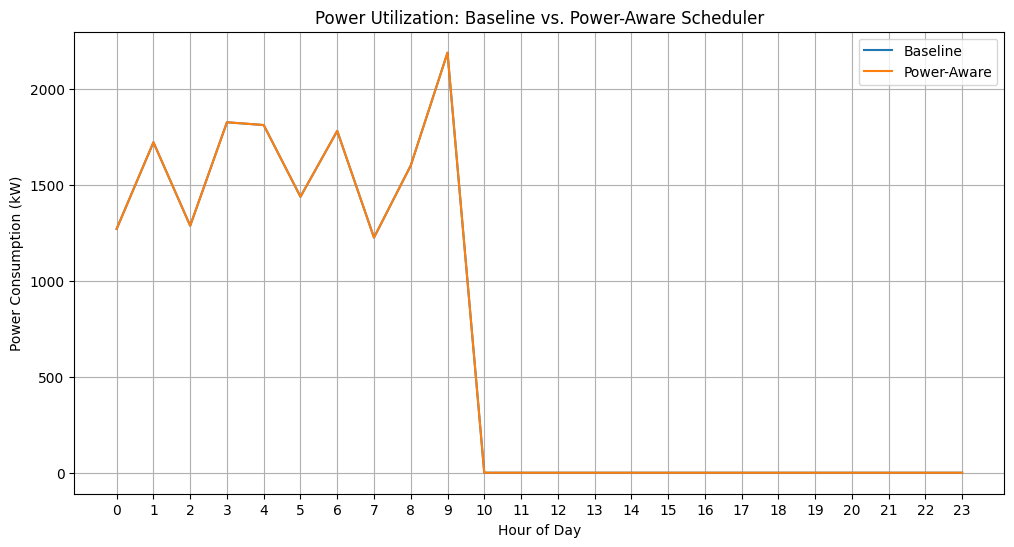

In [43]:
# Run comparison and get hourly power data
baseline_results, power_aware_env, hourly_power_baseline, hourly_power_aware = compare_schedulers(test_jobs, max_jobs=20)

# Create plot
hours = list(range(24))
plt.figure(figsize=(12, 6))
plt.plot(hours, [hourly_power_baseline[h] for h in hours], label='Baseline')
plt.plot(hours, [hourly_power_aware[h] for h in hours], label='Power-Aware')
plt.xlabel('Hour of Day')
plt.ylabel('Power Consumption (kW)')
plt.title('Power Utilization: Baseline vs. Power-Aware Scheduler')
plt.xticks(hours)
plt.legend()
plt.grid(True)
plt.show()
plt.show()

# Tests

Initializing tests...

Test 1: Basic workload
Time 00:00: Scheduled job with power 288.96
Time 00:00: Scheduled job with power 439.78
Time 00:00: Scheduled job with power 235.24
Time 00:00: Scheduled job with power 154.75
Time 00:00: Scheduled job with power 232.26
Time 00:00: Scheduled job with power 57.18
Time 00:00: Scheduled job with power 104.67
Time 00:00: Scheduled job with power 452.67
Time 00:00: Scheduled job with power 422.93
Time 00:00: Scheduled job with power 168.46
Time 00:00: Scheduled job with power 231.79
Time 00:00: Scheduled job with power 216.87
Time 00:00: Scheduled job with power 164.88
Time 00:00: Scheduled job with power 62.13
Time 00:00: Scheduled job with power 192.61
Time 00:00: Scheduled job with power 332.86
Time 00:00: Scheduled job with power 311.44
Time 00:00: Scheduled job with power 131.64
Time 00:00: Scheduled job with power 257.73
Time 00:00: Scheduled job with power 164.26
Time 00:00: Scheduled job with power 489.48
Time 00:00: Scheduled job with p

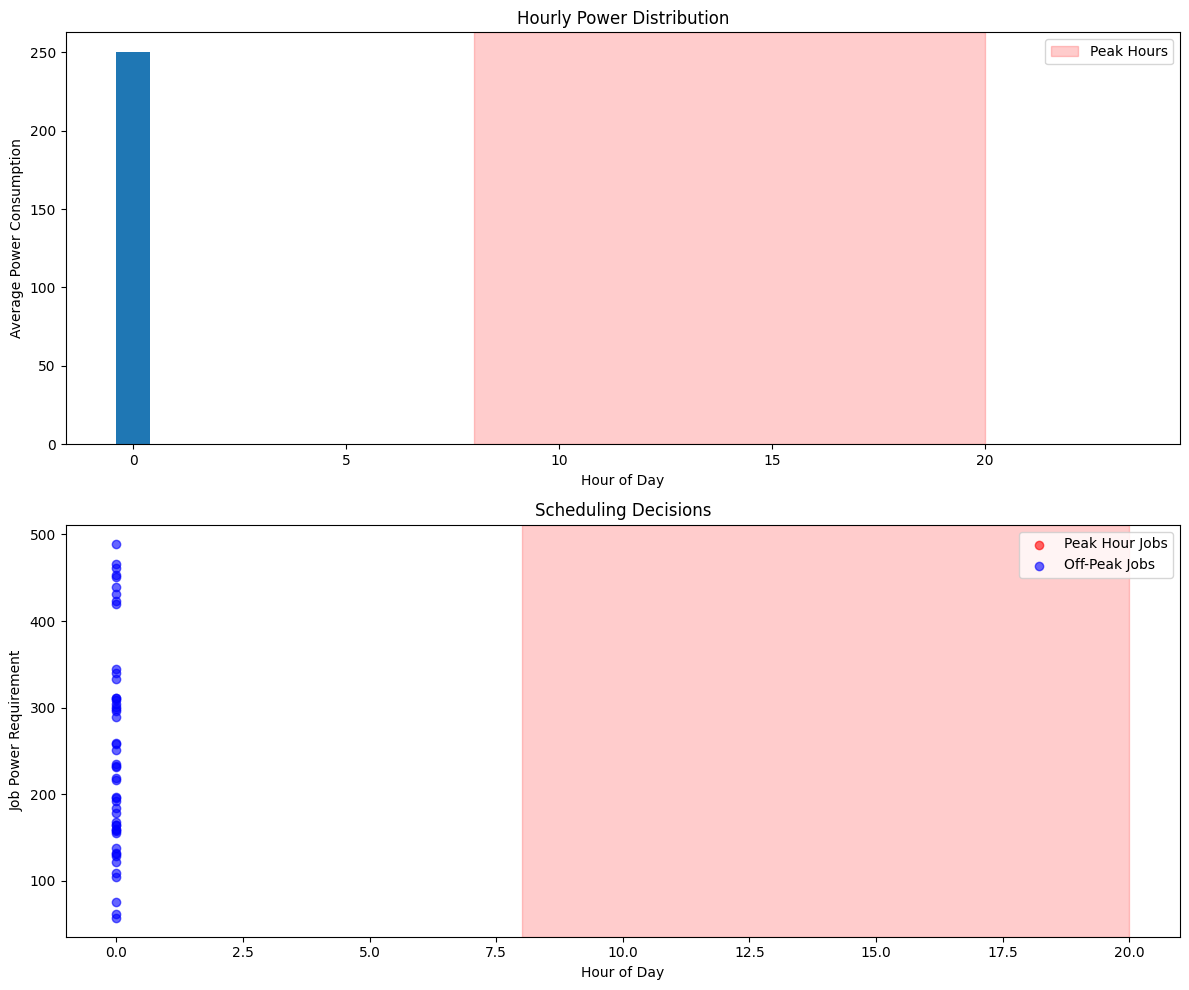


Test 2: High-power workload
Time 00:00: Scheduled job with power 598.27
Time 00:00: Scheduled job with power 892.94
Time 00:00: Scheduled job with power 508.74
Time 00:00: Scheduled job with power 386.22
Time 00:00: Scheduled job with power 503.77
Time 00:00: Scheduled job with power 212.77
Time 00:00: Scheduled job with power 291.12
Time 00:00: Scheduled job with power 915.86
Time 00:00: Scheduled job with power 862.99
Time 00:00: Scheduled job with power 397.44
Time 00:00: Scheduled job with power 502.98
Time 00:00: Scheduled job with power 496.65
Time 00:00: Scheduled job with power 391.46
Time 00:00: Scheduled job with power 220.22
Time 00:00: Scheduled job with power 437.69
Time 00:00: Scheduled job with power 671.43
Time 00:00: Scheduled job with power 635.73
Time 00:00: Scheduled job with power 336.07
Time 00:00: Scheduled job with power 546.22
Time 00:00: Scheduled job with power 403.13
Time 00:00: Scheduled job with power 981.29
Time 00:00: Scheduled job with power 444.73
Tim

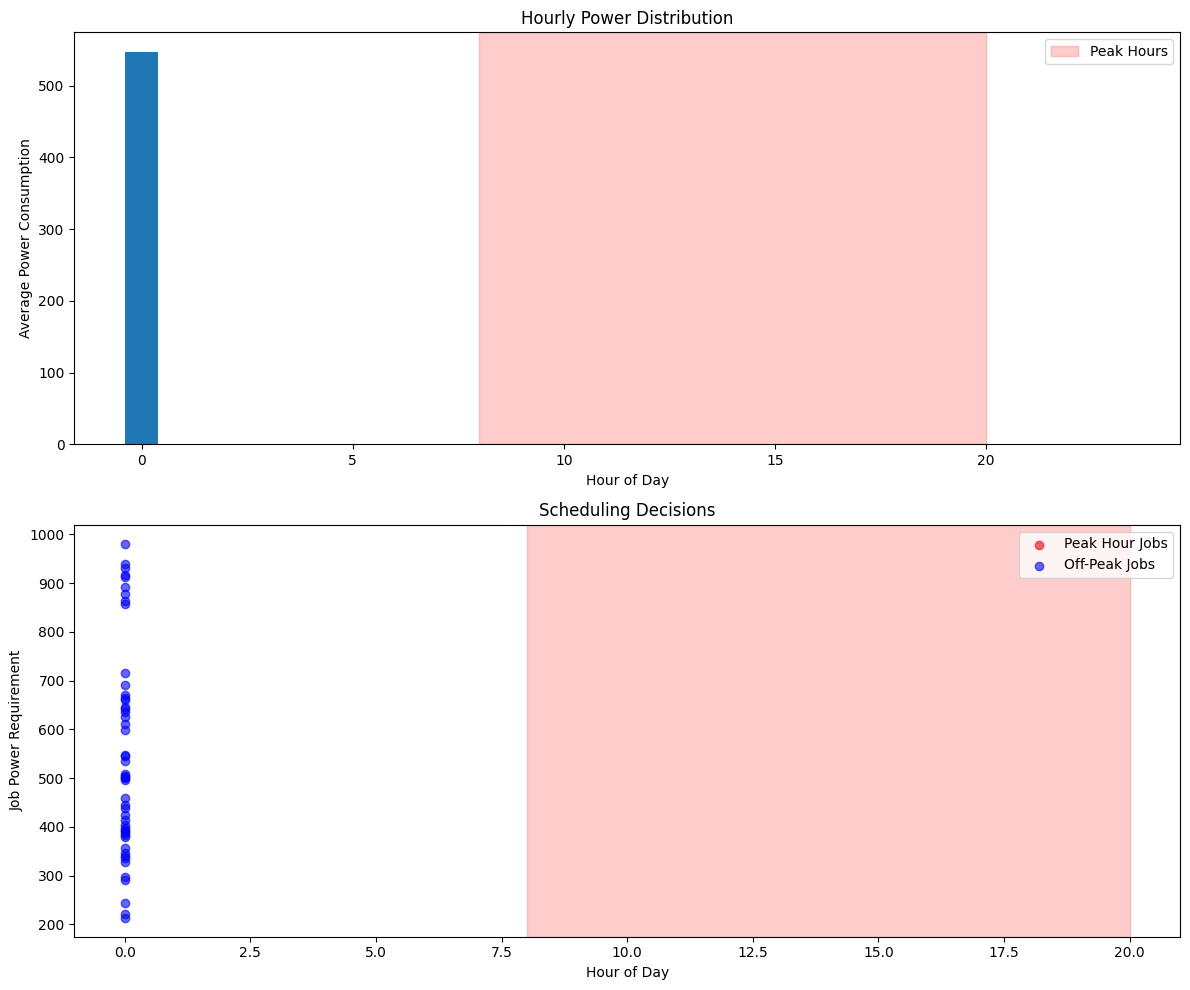

In [47]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

class SchedulerTester:
    def __init__(self, env, actor, feature_scaler, power_scaler):
        self.env = env
        self.actor = actor
        self.feature_scaler = feature_scaler
        self.power_scaler = power_scaler
        
    def generate_test_workload(self, n_jobs=100, power_range=(50, 500)):
        """Generate a test workload with controlled power distribution"""
        np.random.seed(42)
        
        # Create jobs with different power profiles
        jobs = []
        for i in range(n_jobs):
            # Generate more high-power jobs during peak hours
            submit_hour = np.random.randint(0, 24)
            is_peak = 8 <= submit_hour < 20
            
            if is_peak:
                power = np.random.uniform(power_range[0], power_range[1])
            else:
                power = np.random.uniform(power_range[0], power_range[1] * 0.7)
            
            job = {
                'cores_per_task': np.random.randint(1, 16),
                'num_cores_alloc': np.random.randint(16, 128),
                'num_nodes_alloc': np.random.randint(1, 4),
                'num_gpus_alloc': np.random.randint(0, 2),
                'mem_alloc': np.random.randint(1000, 10000),
                'shared': np.random.choice([0, 1]),
                'priority': np.random.randint(1, 5),
                'num_tasks': np.random.randint(1, 8),
                'mean_node_power': power,
                'run_time': np.random.randint(1800, 7200),  # 30 mins to 2 hours
                'submit_time': pd.Timestamp.now().replace(hour=submit_hour, minute=0)
            }
            jobs.append(job)
            
        return jobs
    
    def run_energy_analysis(self, jobs):
        """Run detailed energy analysis on the scheduler"""
        state = self.env.reset()
        job_queue = jobs.copy()
        
        hourly_power = {hour: [] for hour in range(24)}
        job_decisions = []
        
        while len(job_queue) > 0:
            current_job = job_queue[0]
            current_hour = self.env.current_time.hour
            
            # Get scheduler decision
            state_tensor = torch.FloatTensor(state)
            action_probs = self.actor(state_tensor)
            action = torch.argmax(action_probs).item()
            
            # Take action
            next_state, reward, done, info = self.env.step(action, current_job)
            
            if info['scheduled']:
                job_queue.pop(0)
                hourly_power[current_hour].append(current_job['mean_node_power'])
                
                job_decisions.append({
                    'hour': current_hour,
                    'power': current_job['mean_node_power'],
                    'is_peak': 8 <= current_hour < 20,
                    'action_probs': action_probs.detach().numpy(),
                    'decision': 'schedule'
                })
            else:
                job_decisions.append({
                    'hour': current_hour,
                    'power': current_job['mean_node_power'],
                    'is_peak': 8 <= current_hour < 20,
                    'action_probs': action_probs.detach().numpy(),
                    'decision': 'wait'
                })
            
            state = next_state
            if done:
                break
        
        return self.analyze_results(hourly_power, job_decisions)
    
    def analyze_results(self, hourly_power, job_decisions):
        """Analyze the energy efficiency of scheduling decisions with debug information"""
        # Calculate average power per hour
        avg_hourly_power = {h: np.mean(powers) if powers else 0 
                        for h, powers in hourly_power.items()}
        
        # Debug prints
        print("\nDebug Information:")
        print("Hourly power averages:")
        for hour, power in avg_hourly_power.items():
            if 8 <= hour < 20:
                print(f"Peak Hour {hour}: {power:.2f}")
            else:
                print(f"Off-Peak Hour {hour}: {power:.2f}")
        
        # Calculate peak vs off-peak metrics
        peak_powers = []
        offpeak_powers = []
        
        print("\nScheduling decisions:")
        for decision in job_decisions:
            if decision['decision'] == 'schedule':
                if decision['is_peak']:
                    peak_powers.append(decision['power'])
                    print(f"Peak job scheduled: {decision['power']:.2f} at hour {decision['hour']}")
                else:
                    offpeak_powers.append(decision['power'])
                    print(f"Off-peak job scheduled: {decision['power']:.2f} at hour {decision['hour']}")
        
        # Decision analysis
        scheduling_bias = {
            'peak_schedules': len(peak_powers),
            'offpeak_schedules': len(offpeak_powers),
            'avg_peak_power': np.mean(peak_powers) if peak_powers else 0,
            'avg_offpeak_power': np.mean(offpeak_powers) if offpeak_powers else 0
        }
        
        # Calculate energy efficiency metrics with debug
        peak_energy = sum(p for h, p in avg_hourly_power.items() if 8 <= h < 20)
        total_energy = sum(avg_hourly_power.values())
        print(f"\nPeak energy: {peak_energy:.2f}")
        print(f"Total energy: {total_energy:.2f}")
        
        peak_ratio = peak_energy / total_energy if total_energy > 0 else 0
        
        return {
            'hourly_power': avg_hourly_power,
            'scheduling_bias': scheduling_bias,
            'peak_ratio': peak_ratio,
            'total_energy': total_energy,
            'decisions': job_decisions
        }
    
    def test_peak_hour_behavior(self):
        """Test specifically focused on peak hour behavior"""
        print("\nTesting peak hour scheduling behavior...")
        
        # Create a small test workload with known peak hour jobs
        test_jobs = []
        for hour in [10, 14, 18]:  # Peak hours
            job = {
                'cores_per_task': 4,
                'num_cores_alloc': 32,
                'num_nodes_alloc': 1,
                'num_gpus_alloc': 0,
                'mem_alloc': 4000,
                'shared': 0,
                'priority': 3,
                'num_tasks': 2,
                'mean_node_power': 500,  # High power
                'run_time': 3600,  # 1 hour
                'submit_time': pd.Timestamp.now().replace(hour=hour, minute=0)
            }
            test_jobs.append(job)
        
        results = self.run_energy_analysis(test_jobs)
        
        print("\nResults for peak hour test:")
        print(f"Peak/Off-peak ratio: {results['peak_ratio']:.2%}")
        print(f"Peak schedules: {results['scheduling_bias']['peak_schedules']}")
        print(f"Off-peak schedules: {results['scheduling_bias']['offpeak_schedules']}")
        
        return results
    
    def plot_energy_distribution(self, results):
        """Plot energy distribution and scheduling decisions"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Plot 1: Hourly Power Distribution
        hours = list(results['hourly_power'].keys())
        powers = list(results['hourly_power'].values())
        
        ax1.bar(hours, powers)
        ax1.axvspan(8, 20, alpha=0.2, color='red', label='Peak Hours')
        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Average Power Consumption')
        ax1.set_title('Hourly Power Distribution')
        ax1.legend()
        
        # Plot 2: Scheduling Decisions
        decisions = pd.DataFrame(results['decisions'])
        peak_decisions = decisions[decisions['is_peak']]
        offpeak_decisions = decisions[~decisions['is_peak']]
        
        ax2.scatter(peak_decisions['hour'], peak_decisions['power'], 
                   c='red', label='Peak Hour Jobs', alpha=0.6)
        ax2.scatter(offpeak_decisions['hour'], offpeak_decisions['power'], 
                   c='blue', label='Off-Peak Jobs', alpha=0.6)
        ax2.axvspan(8, 20, alpha=0.2, color='red')
        ax2.set_xlabel('Hour of Day')
        ax2.set_ylabel('Job Power Requirement')
        ax2.set_title('Scheduling Decisions')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def run_energy_analysis(self, jobs):
        """Run detailed energy analysis on the scheduler with proper time advancement"""
        state = self.env.reset()
        job_queue = jobs.copy()
        
        hourly_power = {hour: [] for hour in range(24)}
        job_decisions = []
        
        max_time = pd.Timestamp.now().replace(hour=23, minute=59)
        current_time = pd.Timestamp.now().replace(hour=0, minute=0)
        
        while len(job_queue) > 0 and current_time <= max_time:
            current_job = job_queue[0]
            current_hour = current_time.hour
            
            # Get scheduler decision
            state_tensor = torch.FloatTensor(state)
            action_probs = self.actor(state_tensor)
            action = torch.argmax(action_probs).item()
            
            # Take action
            next_state, reward, done, info = self.env.step(action, current_job)
            
            if info['scheduled']:
                job_queue.pop(0)
                hourly_power[current_hour].append(current_job['mean_node_power'])
                
                job_decisions.append({
                    'hour': current_hour,
                    'power': current_job['mean_node_power'],
                    'is_peak': 8 <= current_hour < 20,
                    'action_probs': action_probs.detach().numpy(),
                    'decision': 'schedule'
                })
                
                # Print debug info for each scheduling decision
                print(f"Time {current_time.strftime('%H:%M')}: Scheduled job with power {current_job['mean_node_power']:.2f}")
            else:
                job_decisions.append({
                    'hour': current_hour,
                    'power': current_job['mean_node_power'],
                    'is_peak': 8 <= current_hour < 20,
                    'action_probs': action_probs.detach().numpy(),
                    'decision': 'wait'
                })
                # Advance time if we decide to wait
                current_time += pd.Timedelta(minutes=30)
                
                # Print debug info for wait decisions
                print(f"Time {current_time.strftime('%H:%M')}: Decided to wait. Job power: {current_job['mean_node_power']:.2f}")
            
            state = next_state
            if done:
                break
        
        # Print final scheduling distribution
        print("\nFinal scheduling distribution:")
        for hour in range(24):
            n_jobs = len([d for d in job_decisions if d['hour'] == hour and d['decision'] == 'schedule'])
            print(f"Hour {hour:02d}: {n_jobs} jobs scheduled")
        
        return self.analyze_results(hourly_power, job_decisions)

# Run tests
def run_scheduler_tests():
    print("Initializing tests...")
    tester = SchedulerTester(env, actor, feature_scaler, power_scaler)
    
    # Test 1: Basic workload
    print("\nTest 1: Basic workload")
    basic_jobs = tester.generate_test_workload(n_jobs=50)
    basic_results = tester.run_energy_analysis(basic_jobs)
    
    print(f"Peak/Off-peak ratio: {basic_results['peak_ratio']:.2%}")
    print(f"Total energy consumption: {basic_results['total_energy']:.2f}")
    print("\nScheduling bias:")
    for metric, value in basic_results['scheduling_bias'].items():
        print(f"{metric}: {value:.2f}")
    
    # Visualize results
    tester.plot_energy_distribution(basic_results)
    
    # Test 2: High-power workload
    print("\nTest 2: High-power workload")
    high_power_jobs = tester.generate_test_workload(n_jobs=50, power_range=(200, 1000))
    high_power_results = tester.run_energy_analysis(high_power_jobs)
    
    print(f"Peak/Off-peak ratio: {high_power_results['peak_ratio']:.2%}")
    print(f"Total energy consumption: {high_power_results['total_energy']:.2f}")
    
    tester.plot_energy_distribution(high_power_results)
    
    return basic_results, high_power_results

# Execute tests
basic_results, high_power_results = run_scheduler_tests()

In [48]:
# Initialize the tester with the fixed version
tester = SchedulerTester(env, actor, feature_scaler, power_scaler)

# Run test with time-aware analysis
print("Running test with time advancement...")
test_jobs = tester.generate_test_workload(n_jobs=20)  # Smaller test set for clarity
results = tester.run_energy_analysis(test_jobs)

# Print summary
print("\nResults Summary:")
print(f"Peak/Off-peak ratio: {results['peak_ratio']:.2%}")
print(f"Total energy consumption: {results['total_energy']:.2f}")
print(f"Peak schedules: {results['scheduling_bias']['peak_schedules']}")
print(f"Off-peak schedules: {results['scheduling_bias']['offpeak_schedules']}")

Running test with time advancement...
Time 00:00: Scheduled job with power 288.96
Time 00:00: Scheduled job with power 439.78
Time 00:00: Scheduled job with power 235.24
Time 00:00: Scheduled job with power 154.75
Time 00:00: Scheduled job with power 232.26
Time 00:00: Scheduled job with power 57.18
Time 00:00: Scheduled job with power 104.67
Time 00:00: Scheduled job with power 452.67
Time 00:00: Scheduled job with power 422.93
Time 00:00: Scheduled job with power 168.46
Time 00:00: Scheduled job with power 231.79
Time 00:00: Scheduled job with power 216.87
Time 00:00: Scheduled job with power 164.88
Time 00:00: Scheduled job with power 62.13
Time 00:00: Scheduled job with power 192.61
Time 00:00: Scheduled job with power 332.86
Time 00:00: Scheduled job with power 311.44
Time 00:00: Scheduled job with power 131.64
Time 00:00: Scheduled job with power 257.73
Time 00:00: Scheduled job with power 164.26

Final scheduling distribution:
Hour 00: 20 jobs scheduled
Hour 01: 0 jobs scheduled